In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action="ignore")
# from ydata_profiling import ProfileReport

import datetime

In [7]:
lending_data = pd.read_csv("/Users/pavithrapishe/Downloads/loan.csv")
lending_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [8]:
lending_data.shape

(39717, 111)

In [9]:
categorical = ['term', 'grade','sub_grade','emp_length','home_ownership','verification_status',
               'issue_d','loan_status','purpose','pub_rec', 'pub_rec_bankruptcies','delinq_2yrs']
continous = ['loan_amnt','funded_amnt','funded_amnt_inv','inq_last_6mths',
             'int_rate','installment','annual_inc','dti','earliest_cr_line',
            'open_acc','revol_bal','revol_util','total_acc','out_prncp','out_prncp_inv',
            'total_pymnt','total_pymnt_inv', 'total_rec_prncp','total_rec_int','total_rec_late_fee',
            'recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','last_credit_pull_d']
extra = ['id','member_id','zip_code','url','desc','title','emp_title','addr_state']

Get the list of all columns with all Null values and drop them

In [10]:
lending_data = lending_data.dropna(axis = 1, how = 'all')
lending_data.shape

(39717, 57)

Get the list of columns that have only 1 value in it and drop them since they dont contribute much to analysis

In [11]:
single_val_col = lending_data.columns[lending_data.nunique() == 1]
single_val_col

Index(['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'],
      dtype='object')

In [12]:
lending_data = lending_data.drop(single_val_col, axis = 1)
lending_data.shape

(39717, 48)

Get the Extra Columns that do not contribute much to analysis since the target here is to find the defaulter.

In [13]:
lending_data = lending_data.drop(extra, axis= 1)
lending_data.shape

(39717, 40)

In [14]:
lending_data.columns.to_list()

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'pub_rec_bankruptcies']

In [15]:
lending_data.isna().sum()

loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
term                           0
int_rate                       0
installment                    0
grade                          0
sub_grade                      0
emp_length                  1075
home_ownership                 0
annual_inc                     0
verification_status            0
issue_d                        0
loan_status                    0
purpose                        0
dti                            0
delinq_2yrs                    0
earliest_cr_line               0
inq_last_6mths                 0
mths_since_last_delinq     25682
mths_since_last_record     36931
open_acc                       0
pub_rec                        0
revol_bal                      0
revol_util                    50
total_acc                      0
out_prncp                      0
out_prncp_inv                  0
total_pymnt                    0
total_pymnt_inv                0
total_rec_

Dropping columns 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d' since they have more than 90% NA data.

In [16]:
lending_data = lending_data.drop(['mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d'], axis= 1)
lending_data.shape

(39717, 37)

Remove all the rows that have loan status = "Current" since Applicant is in the process of paying the instalments, i.e. the tenure of the loan is not yet completed. These candidates are not labelled as 'defaulted'.

In [17]:
lending_data = lending_data[~(lending_data['loan_status'] == 'Current')]
lending_data['loan_status'].value_counts()

Fully Paid     32950
Charged Off     5627
Name: loan_status, dtype: int64

### Handle missing values

In [18]:
lending_data.isna().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_length                 1033
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                   50
total_acc                     0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_pymnt_inv               0
total_rec_prncp               0
total_rec_int                 0
total_rec_late_fee            0
recoveri

As per the command data above, there are 4 columns that has missing values 'emp_length','revol_util','last_pymnt_d','last_credit_pull_d' and 'pub_rec_bankruptcies'

'revol_util','last_pymnt_d','last_credit_pull_d' - have relatively less null values. And its safe to delete these rows.

In [19]:
lending_data = lending_data.dropna(axis = 0, subset = ['revol_util','last_pymnt_d','last_credit_pull_d'])

In [20]:
lending_data.isna().sum()

loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_length                 1025
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_pymnt_inv               0
total_rec_prncp               0
total_rec_int                 0
total_rec_late_fee            0
recoveri

Checking the data present in 'emp_length' and 'pub_rec_bankruptcies'

In [21]:
lending_data['emp_length'].value_counts()

10+ years    8478
< 1 year     4488
2 years      4280
3 years      4001
4 years      3328
5 years      3180
1 year       3154
6 years      2164
7 years      1707
8 years      1430
9 years      1223
Name: emp_length, dtype: int64

In [22]:
lending_data['pub_rec_bankruptcies'].value_counts()

0.0    36127
1.0     1630
2.0        5
Name: pub_rec_bankruptcies, dtype: int64

Imputing the Null values with mode values for 'emp_length' and 'pub_rec_bankruptcies' as they are all categorical.

In [23]:
lending_data['emp_length'] = lending_data['emp_length'].fillna(lending_data['emp_length'].mode()[0])
lending_data['pub_rec_bankruptcies'] = lending_data['pub_rec_bankruptcies'].fillna(lending_data['pub_rec_bankruptcies'].mode()[0])

### Converting data to proper form and format

'emp_length' is observed to be an object since it contains '+' 'years' etc. Removing these values and considering only the numeric part for this column

In [24]:
lending_data['emp_length'] = (lending_data['emp_length'].str.extract('(\d+)')).astype('int64')

'term' is observed to be an object since it contains 'months'. Removing these values and considering only the numeric part for this column

In [25]:
lending_data['term'] = (lending_data['term'].str.extract('(\d+)')).astype('int64')

'int_rate' is observed to be an object since it contains '%'. Removing these values and considering only the numeric part for this column

In [26]:
lending_data['int_rate'] = (lending_data['int_rate'].str.extract('(\d+)')).astype('float64')

'revol_util' is observed to be an object since it contains '%'. Removing these values and considering only the numeric part for this column

In [27]:
lending_data['revol_util'] = (lending_data['revol_util'].str.extract('(\d+)')).astype('float64')

In [28]:
lending_data.shape

(38458, 37)

## Univariate analysis

In [29]:
lending_data[continous].describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,38458.0,11060.022622,7346.814917,500.00,5375.00000,9700.000000,15000.000000,3.500000e+04
funded_amnt,38458.0,10796.242004,7088.275073,500.00,5200.00000,9600.000000,15000.000000,3.500000e+04
funded_amnt_inv,38458.0,10236.629675,7022.449721,0.00,5000.00000,8756.517556,14000.000000,3.500000e+04
inq_last_6mths,38458.0,0.871080,1.071353,0.00,0.00000,1.000000,1.000000,8.000000e+00
int_rate,38458.0,11.349316,3.724052,5.00,8.00000,11.000000,14.000000,2.400000e+01
installment,38458.0,322.796147,208.591916,15.69,165.82500,278.240000,426.100000,1.305190e+03
annual_inc,38458.0,68845.502462,64255.799973,4000.00,40000.00000,59000.000000,82000.000000,6.000000e+06
dti,38458.0,13.278672,6.670271,0.00,8.14000,13.370000,18.560000,2.999000e+01
open_acc,38458.0,9.284960,4.400480,2.00,6.00000,9.000000,12.000000,4.400000e+01
revol_bal,38458.0,13316.760128,15876.681164,0.00,3675.00000,8784.500000,16943.000000,1.495880e+05


### Visualizing continous data and checking for any outliers

filtering out numeric values from continous

In [30]:
continous_numeric = ['loan_amnt','funded_amnt','funded_amnt_inv','inq_last_6mths',
             'int_rate','installment','annual_inc','dti',
            'open_acc','revol_bal','revol_util','total_acc','out_prncp','out_prncp_inv',
            'total_pymnt','total_pymnt_inv', 'total_rec_prncp','total_rec_int','total_rec_late_fee',
            'recoveries','collection_recovery_fee','last_pymnt_amnt']

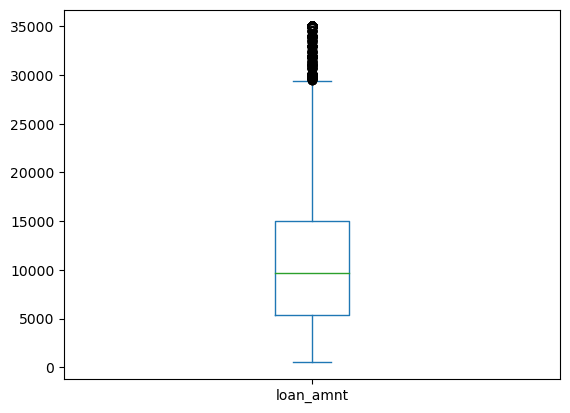

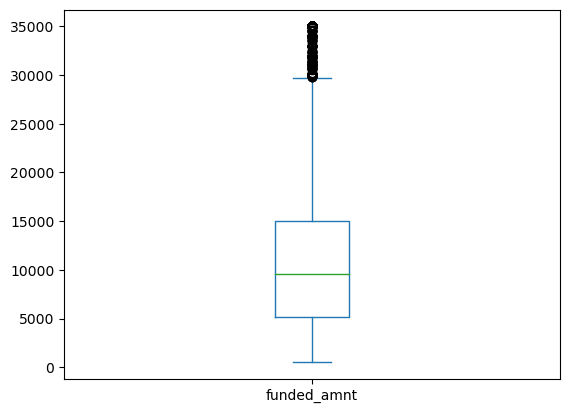

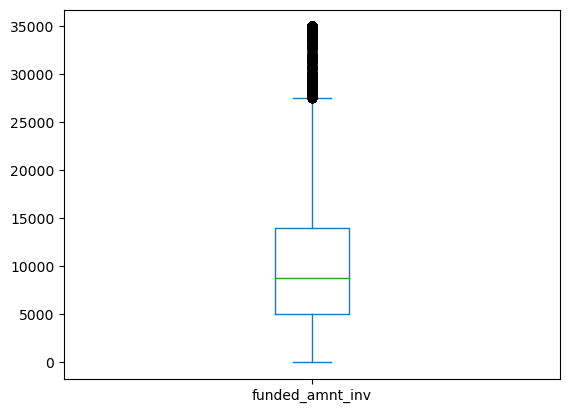

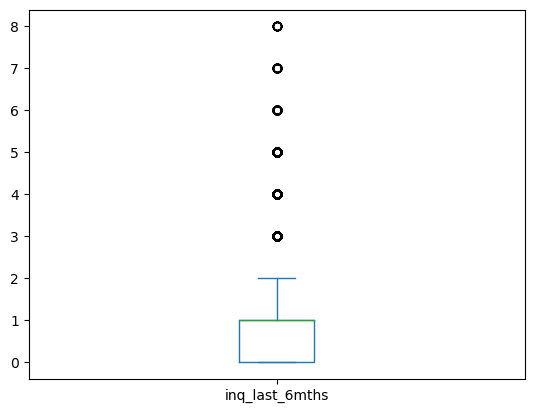

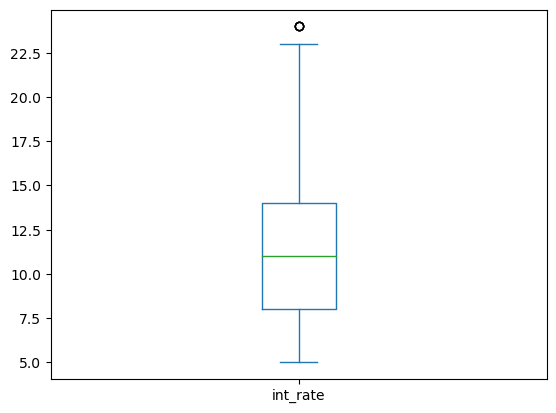

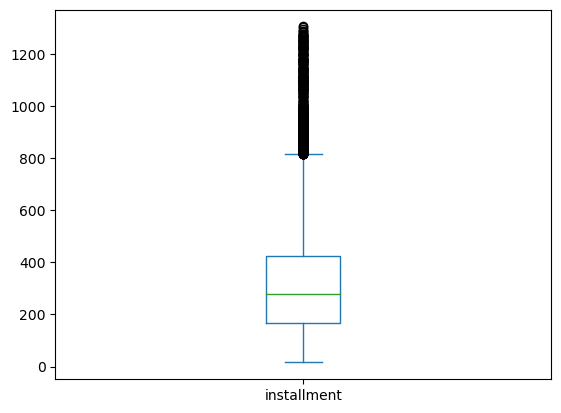

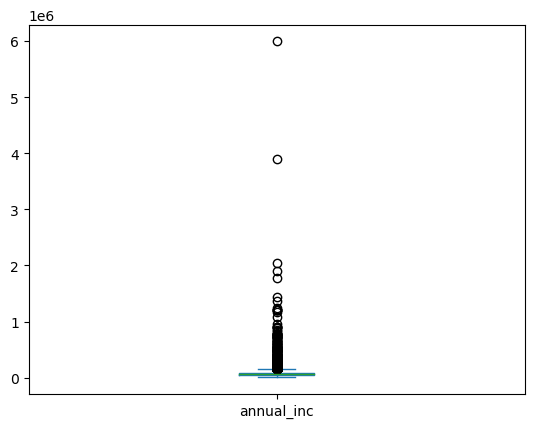

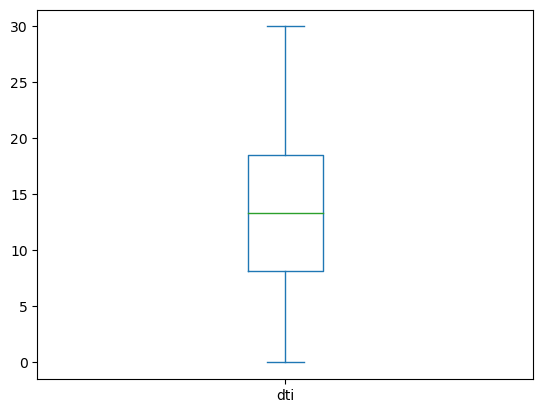

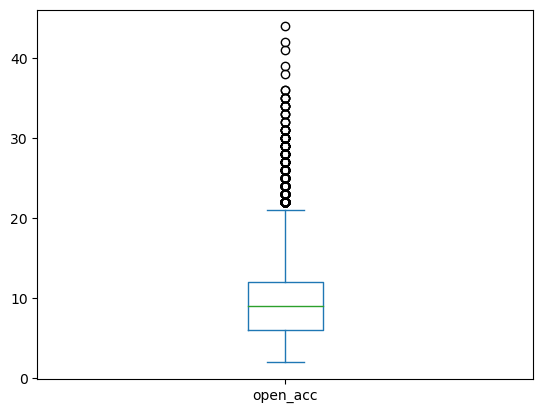

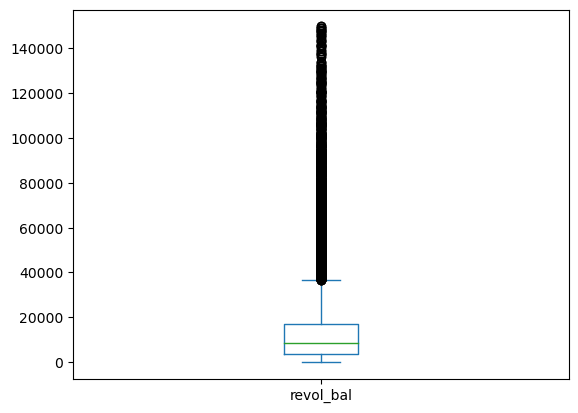

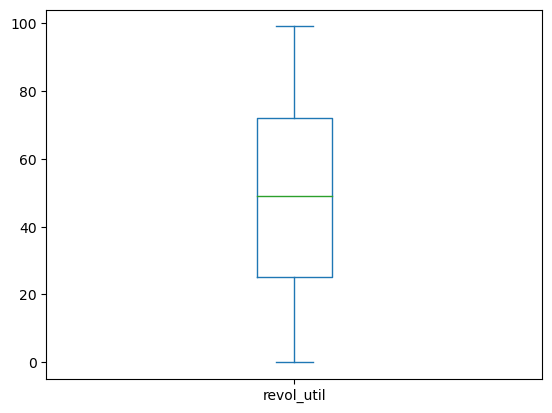

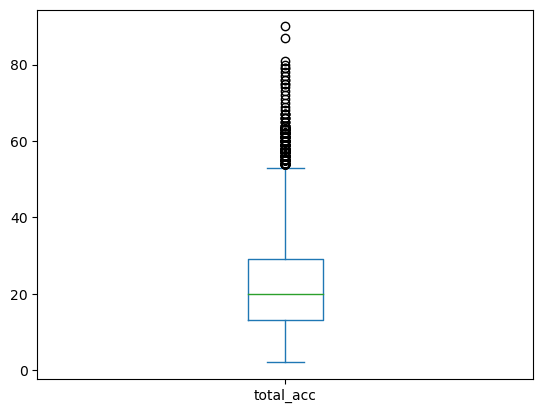

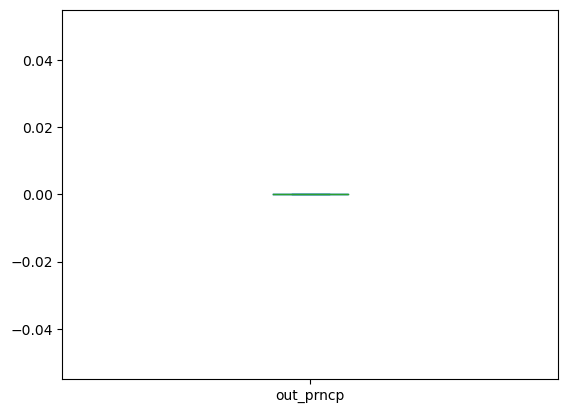

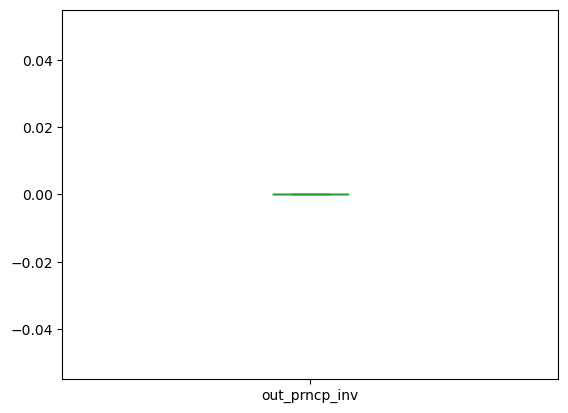

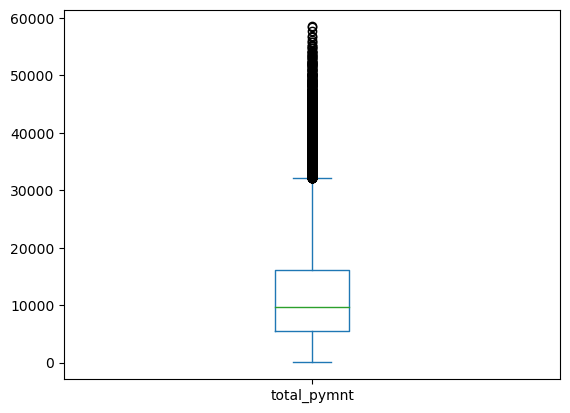

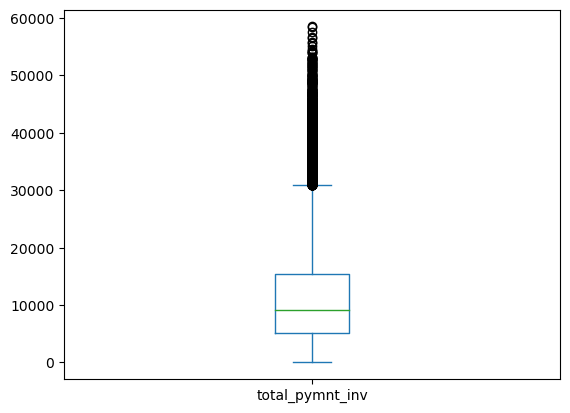

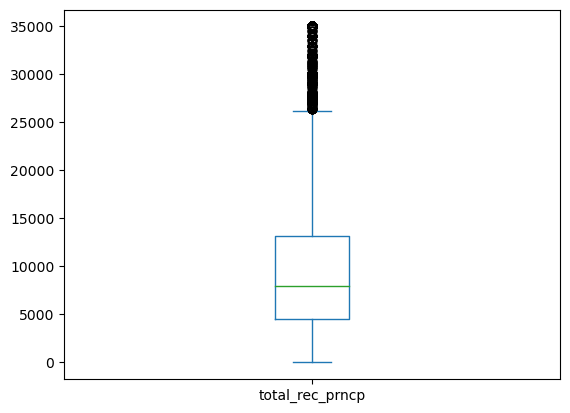

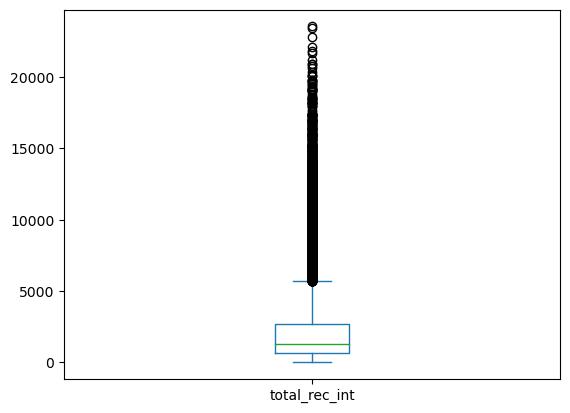

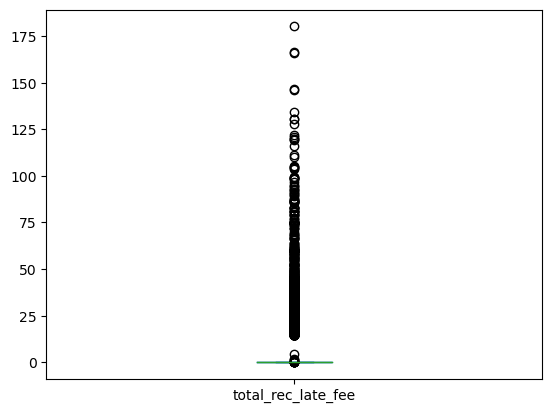

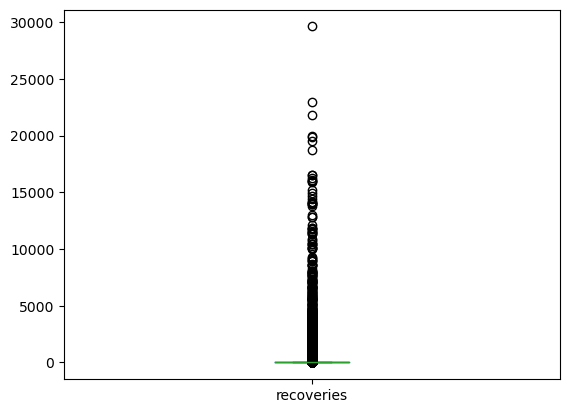

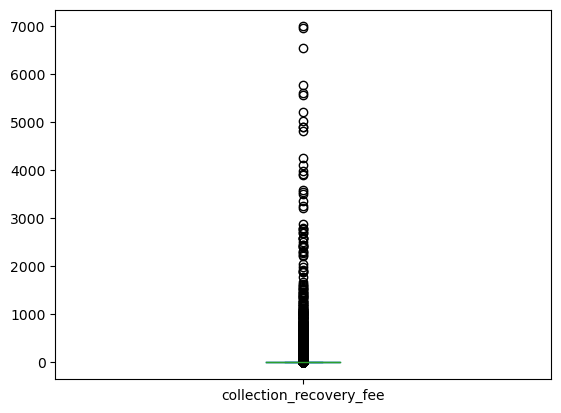

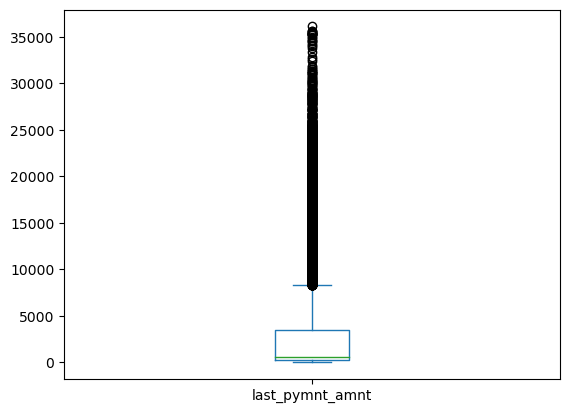

In [31]:
for i in continous_numeric:
    lending_data[i].plot(kind='box')
    plt.show()

The plots above clearly shows outliers in a lot of columns. Extreme outlier is seen in column 'annual_inc' Handling them using the standard deviation method.

In [32]:
# lending_data['annual_inc'].describe().apply("{0:.3f}".format)
data_std = round((lending_data['annual_inc'].std()), 3)
data_mean = round((lending_data['annual_inc'].mean()), 3)

In [33]:
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
# remove outliers
loan_data = lending_data.loc[((lending_data['annual_inc'] >= lower) & (lending_data['annual_inc'] <= upper))]

### 'lending_data' become 'loan_data' after removing outliers

In [34]:
loan_data.shape

(38180, 37)

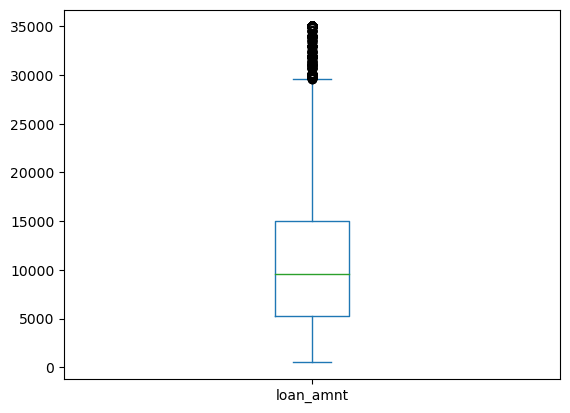

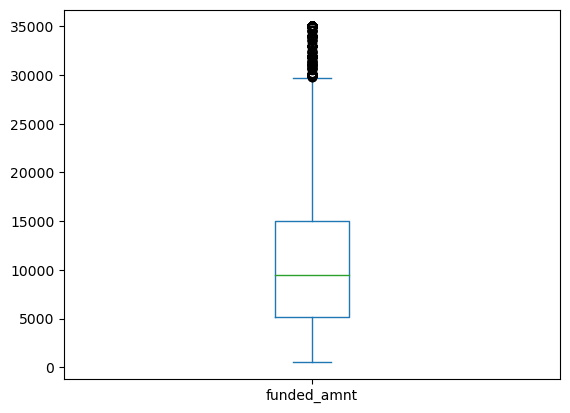

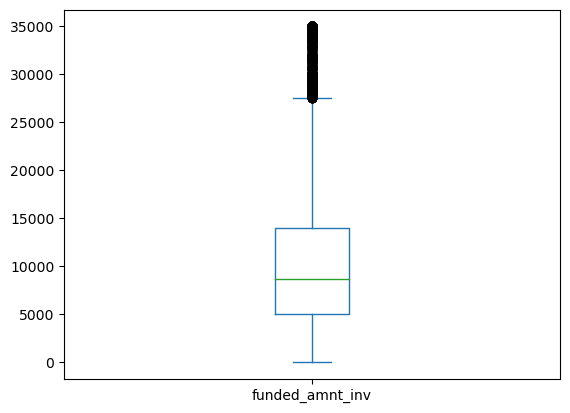

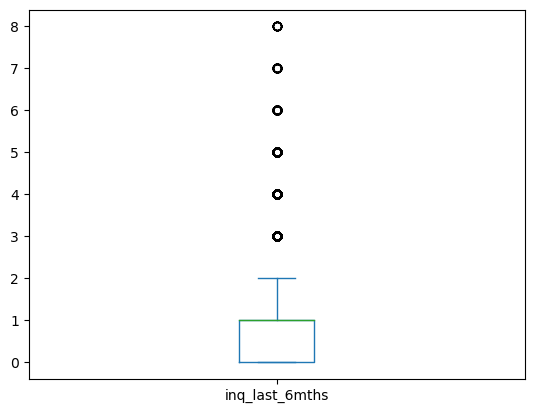

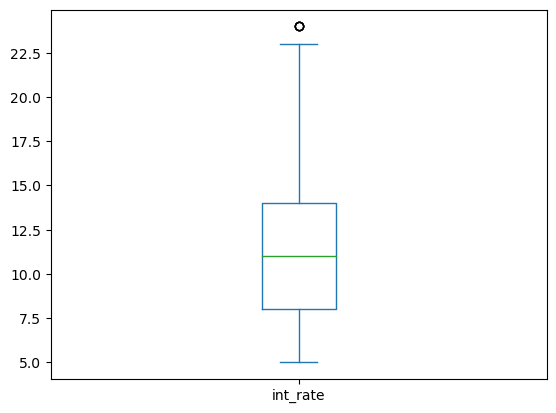

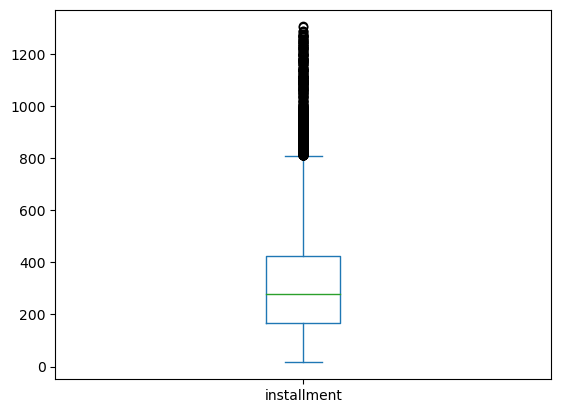

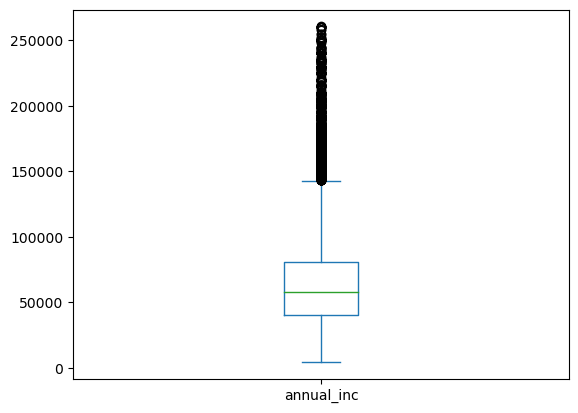

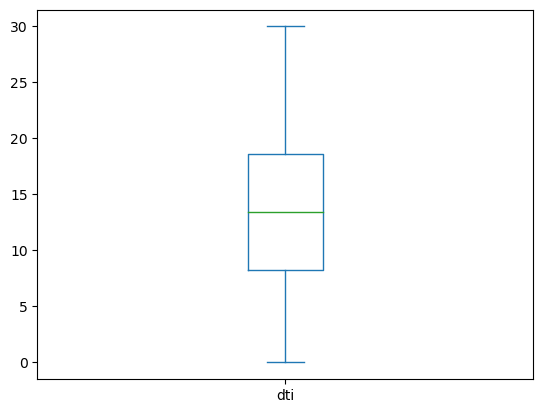

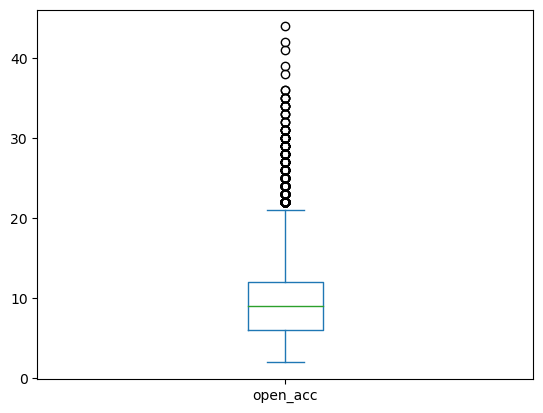

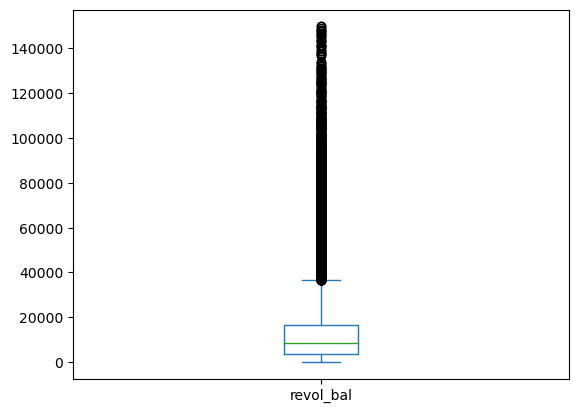

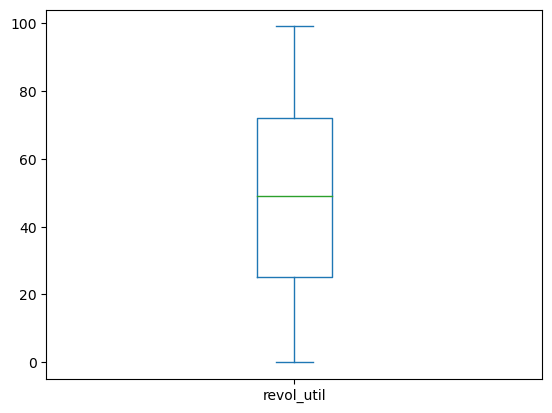

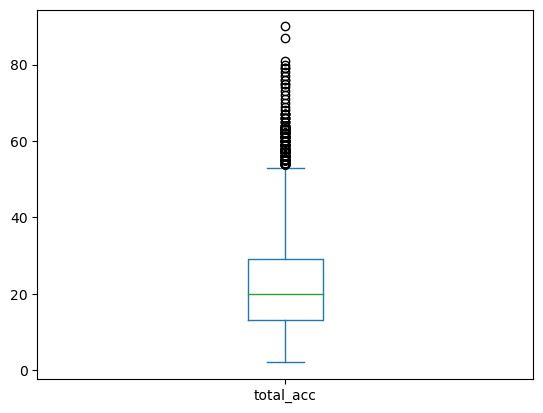

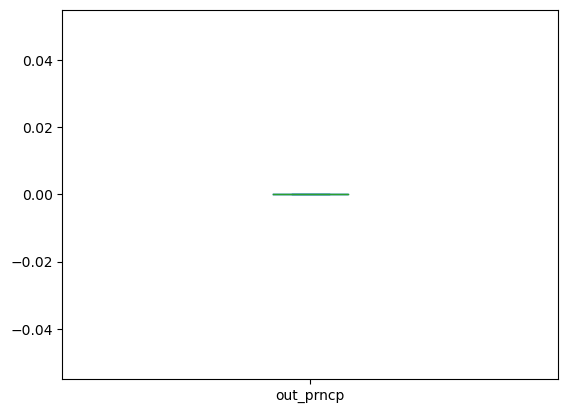

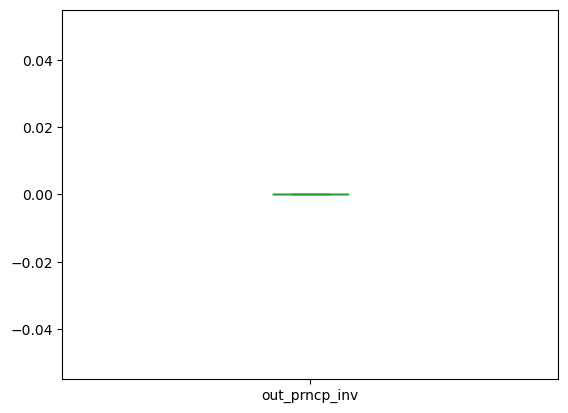

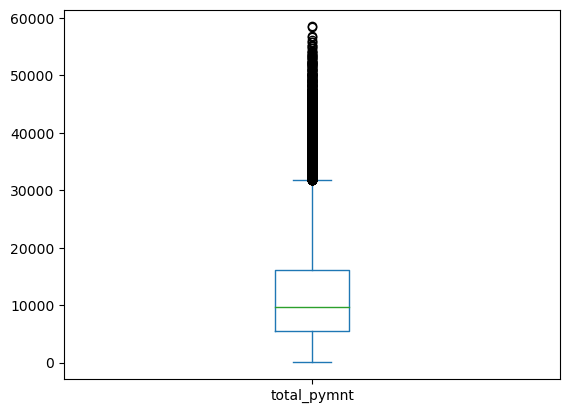

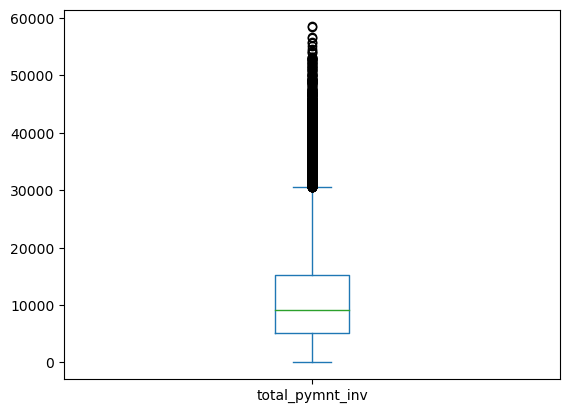

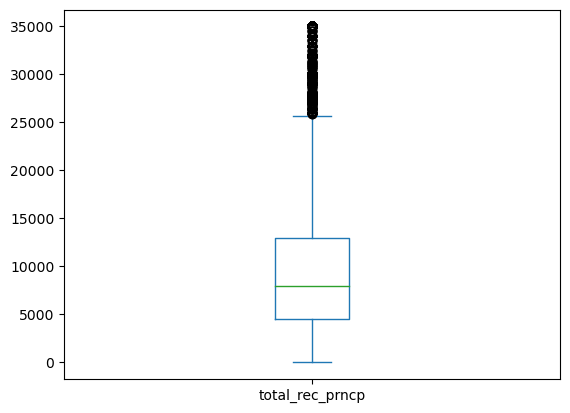

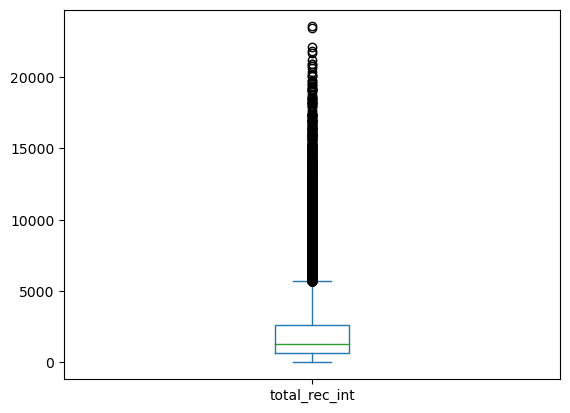

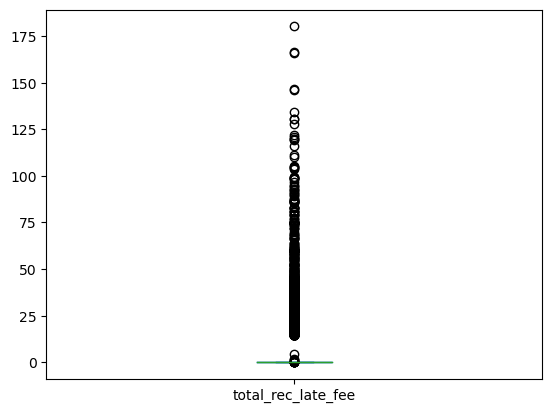

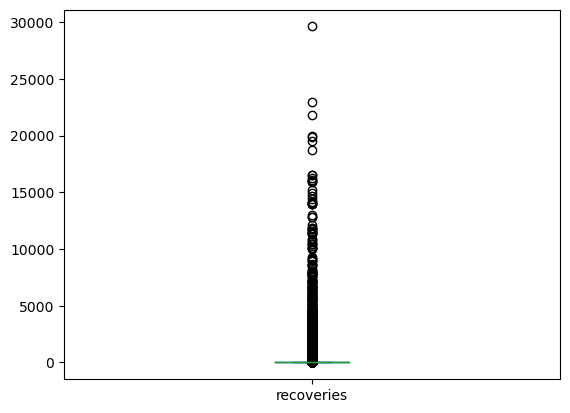

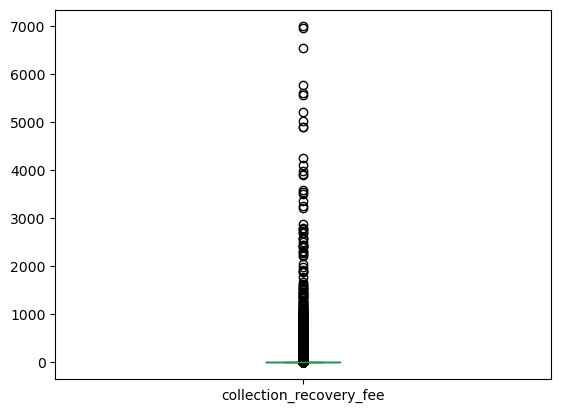

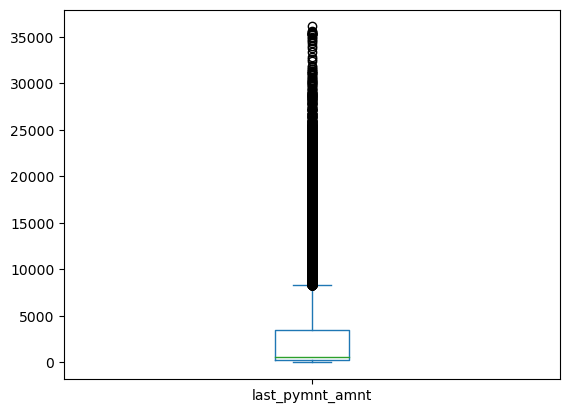

In [35]:
for i in continous_numeric:
    loan_data[i].plot(kind='box')
    plt.show()

Looking for unique values again and dropping them if present

In [36]:
loan_data.nunique()

loan_amnt                    867
funded_amnt                 1015
funded_amnt_inv             7978
term                           2
int_rate                      20
installment                14910
grade                          7
sub_grade                     35
emp_length                    10
home_ownership                 5
annual_inc                  5076
verification_status            3
issue_d                       55
loan_status                    2
purpose                       14
dti                         2853
delinq_2yrs                   11
earliest_cr_line             524
inq_last_6mths                 9
open_acc                      40
pub_rec                        5
revol_bal                  21099
revol_util                   100
total_acc                     82
out_prncp                      1
out_prncp_inv                  1
total_pymnt                36345
total_pymnt_inv            36027
total_rec_prncp             6791
total_rec_int              33742
total_rec_

In [37]:
single_val_col_loan_data = loan_data.columns[loan_data.nunique() == 1]
single_val_col_loan_data

Index(['out_prncp', 'out_prncp_inv'], dtype='object')

In [38]:
loan_data = loan_data.drop(single_val_col_loan_data, axis = 1)
loan_data.shape

(38180, 35)

In [39]:
loan_data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'pub_rec_bankruptcies'],
      dtype='object')

Filtering out redundant columns
- Dropping 'funded_amnt' as 'funded_amnt_inv' can be used.
- Dropping 'total_pymnt' as 'total_pymnt_inv' can be used.


In [40]:
loan_data = loan_data.drop(['funded_amnt','total_pymnt'], axis = 1)
loan_data.shape

(38180, 33)

### Visualizing categorical data and binning them if required

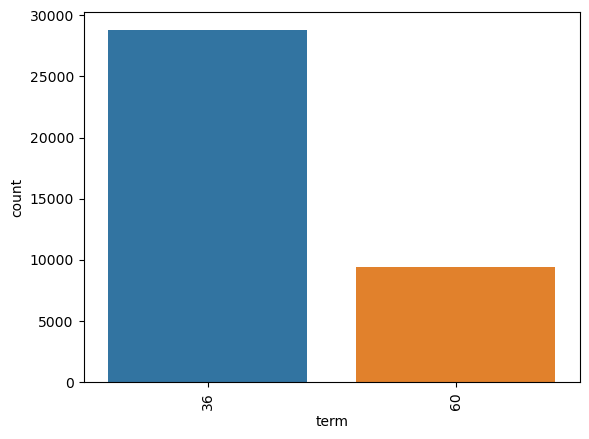

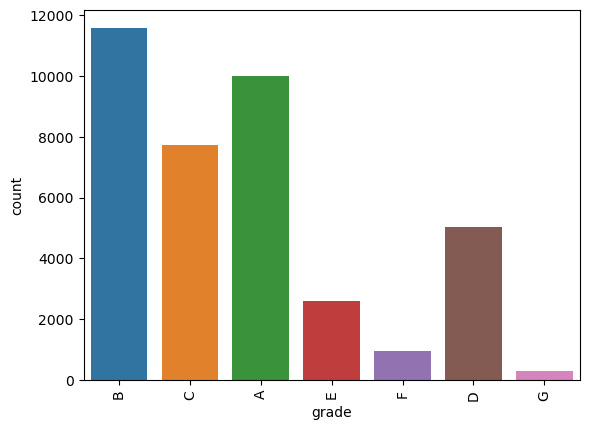

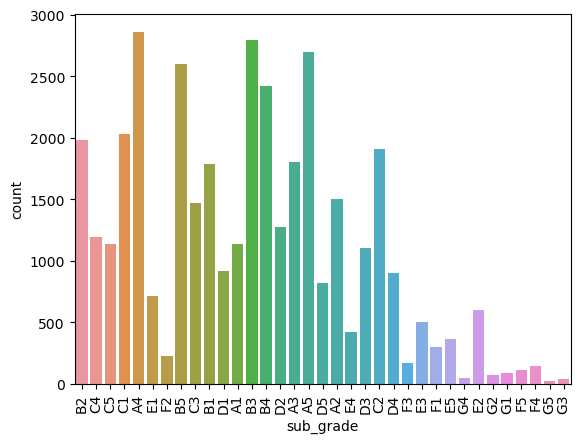

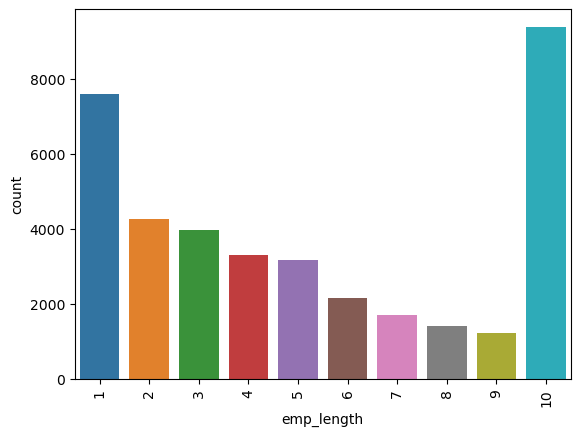

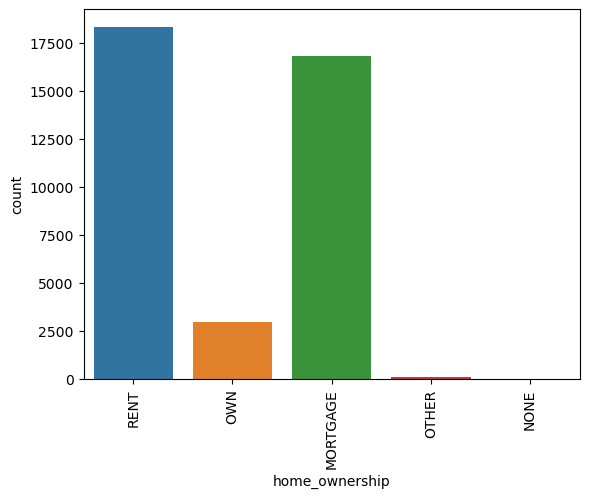

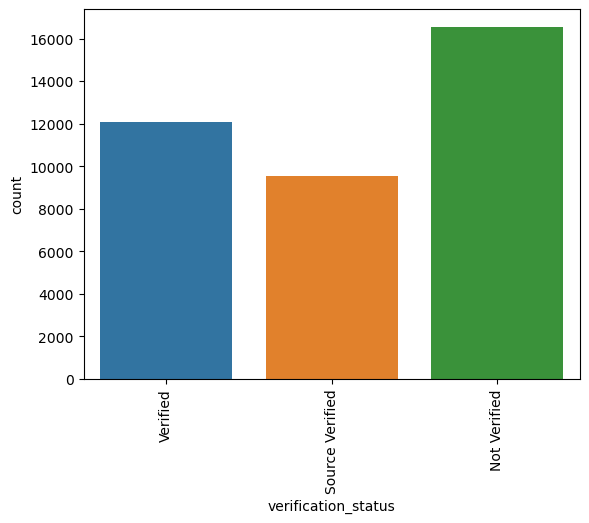

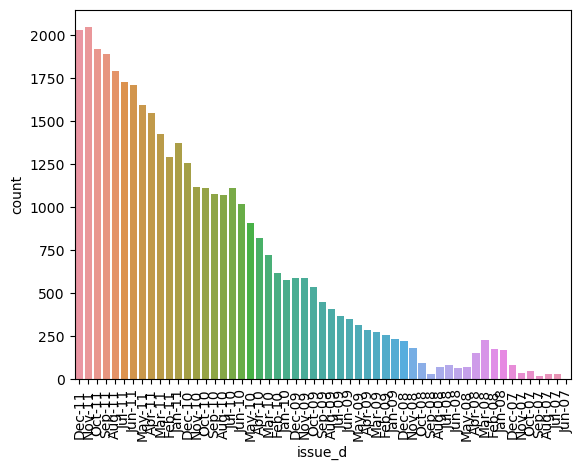

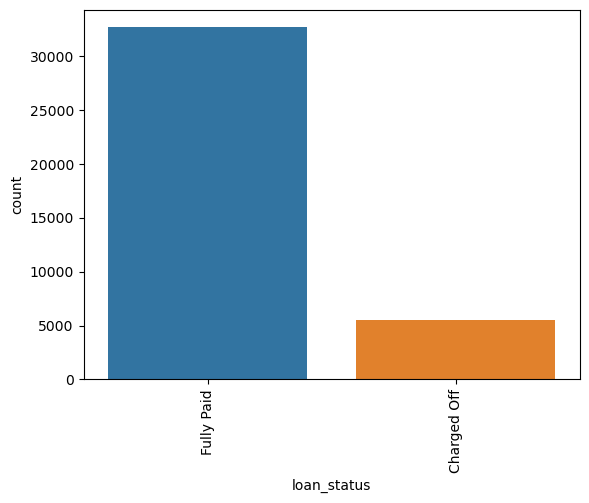

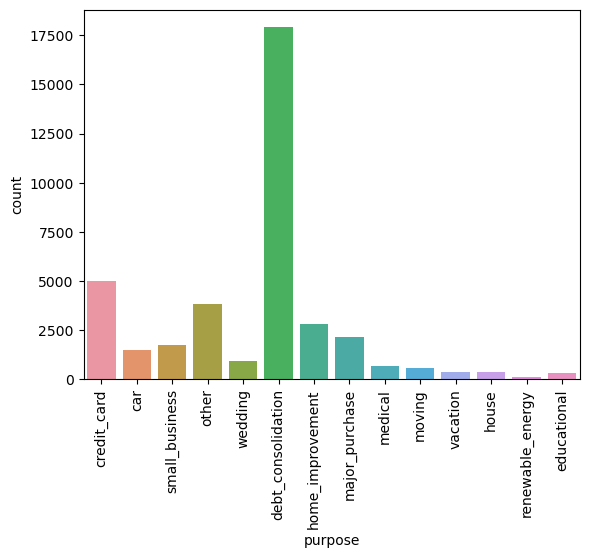

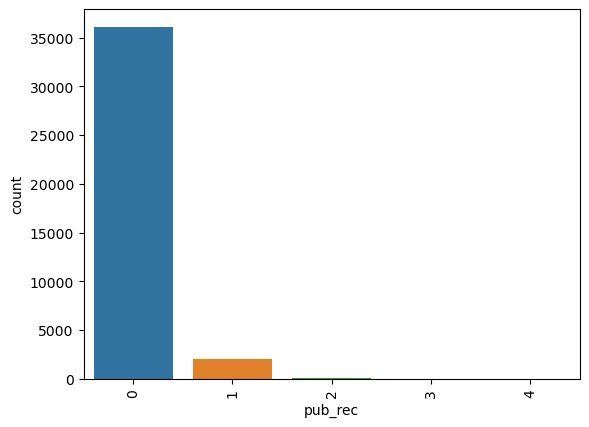

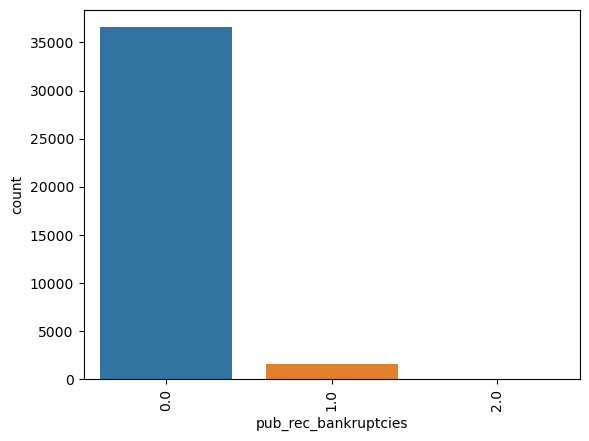

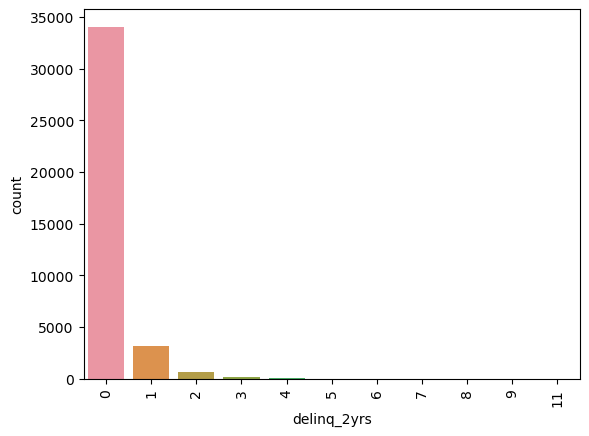

In [41]:
for i in categorical:
    sns.countplot(x=loan_data[i])
    plt.xticks(rotation = 90 )
    plt.show()

### Observations from Univariate analysis

## Bivariate analysis

### Analysis columns against 'loan_status'

In [42]:
loan_data[loan_data.loan_status=='Charged Off']

,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
1,2500,2500.0,60,15.0,59.83,C,C4,1,RENT,30000.0,...,1008.71,456.46,435.17,0.00,117.08,1.1100,Apr-13,119.66,Sep-13,0.0
8,5600,5600.0,60,21.0,152.39,F,F2,4,OWN,40000.0,...,646.02,162.02,294.94,0.00,189.06,2.0900,Apr-12,152.39,Aug-12,0.0
9,5375,5350.0,60,12.0,121.45,B,B5,1,RENT,15000.0,...,1469.34,673.48,533.42,0.00,269.29,2.5200,Nov-12,121.45,Mar-13,0.0
12,9000,9000.0,36,13.0,305.38,C,C1,1,RENT,30000.0,...,2270.70,1256.14,570.26,0.00,444.30,4.1600,Jul-12,305.38,Nov-12,0.0
14,10000,10000.0,36,10.0,325.74,B,B2,3,RENT,100000.0,...,7471.99,5433.47,1393.42,0.00,645.10,6.3145,Oct-13,325.74,Mar-14,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39667,2500,675.0,36,12.0,84.00,D,D4,1,MORTGAGE,32000.0,...,599.28,1706.01,477.21,1.69,35.70,0.3800,Mar-10,1.76,May-16,0.0
39668,2500,825.0,36,9.0,80.26,B,B4,1,MORTGAGE,75000.0,...,688.35,1730.83,354.44,1.36,0.00,0.0000,Mar-10,1.40,May-16,0.0
39669,6500,225.0,36,15.0,225.37,F,F1,9,MORTGAGE,213000.0,...,139.42,2886.21,1168.14,0.00,0.00,0.0000,Feb-09,225.37,May-16,0.0
39678,1000,950.0,36,10.0,32.55,C,C2,2,MORTGAGE,33990.0,...,668.87,544.02,138.64,0.00,21.29,0.2300,May-09,32.55,Oct-09,0.0


In [43]:
loan_data.columns

Index(['loan_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment',
       'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'last_credit_pull_d', 'pub_rec_bankruptcies'],
      dtype='object')

### Analysing 'loan_amnt', against 'loan_status' by creating group of 'loan_amnt'

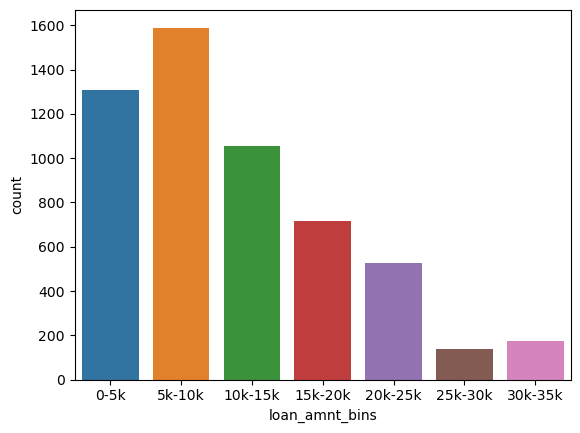

In [44]:
loan_data['loan_amnt_bins'] = pd.cut(loan_data['loan_amnt'], bins=7,labels=['0-5k','5k-10k','10k-15k','15k-20k','20k-25k','25k-30k','30k-35k'])
sns.countplot(x='loan_amnt_bins', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()

### Analysing 'term' against 'charged off' loans

<Axes: xlabel='count', ylabel='term'>

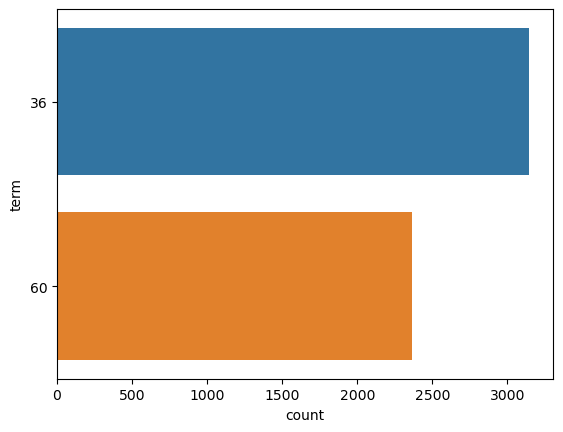

In [45]:
sns.countplot(y='term', data=loan_data[loan_data['loan_status']=='Charged Off'])

### Analysis 'int_rate' against 'charged off' loans by creating int_rate bins

In [46]:
loan_data['int_rate'].describe()

count    38180.000000
mean        11.338318
std          3.718939
min          5.000000
25%          8.000000
50%         11.000000
75%         14.000000
max         24.000000
Name: int_rate, dtype: float64

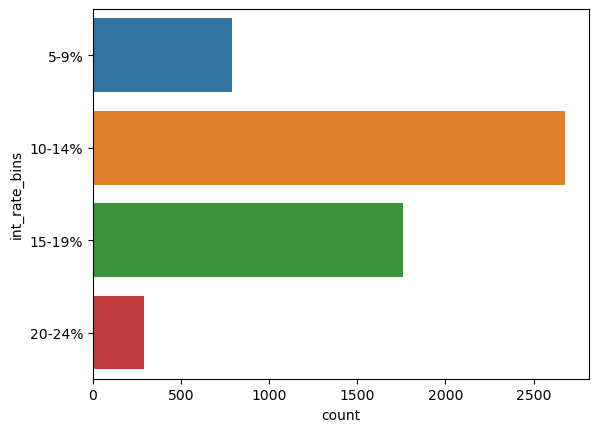

In [47]:
loan_data['int_rate_bins'] = pd.cut(loan_data['int_rate'], bins=4,labels=['5-9%','10-14%','15-19%','20-24%'])
sns.countplot(y='int_rate_bins', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()

### Analysis 'installment' against 'charged off' loans by creating installment bins

In [48]:
loan_data['installment'].describe()

count    38180.000000
mean       320.972073
std        206.628873
min         15.690000
25%        165.687500
50%        277.130000
75%        423.400000
max       1305.190000
Name: installment, dtype: float64

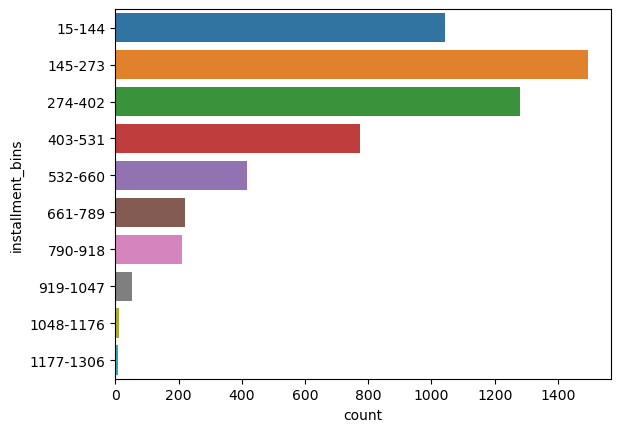

In [49]:
loan_data['installment_bins'] = pd.cut(loan_data['installment'], bins=10,labels=['15-144','145-273','274-402','403-531','532-660','661-789','790-918','919-1047','1048-1176','1177-1306'])
sns.countplot(y='installment_bins', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()

### Anaylysing 'grade' and 'sub grade'

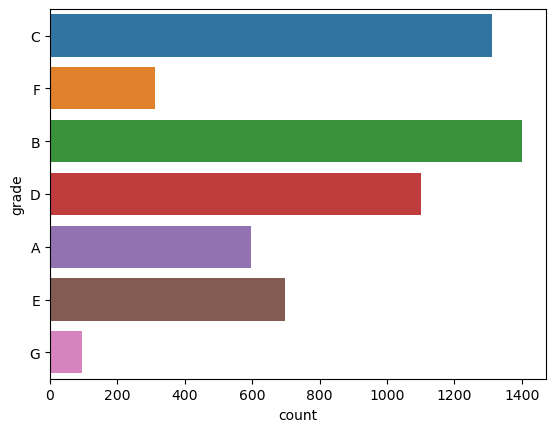

In [50]:
sns.countplot(y='grade', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()

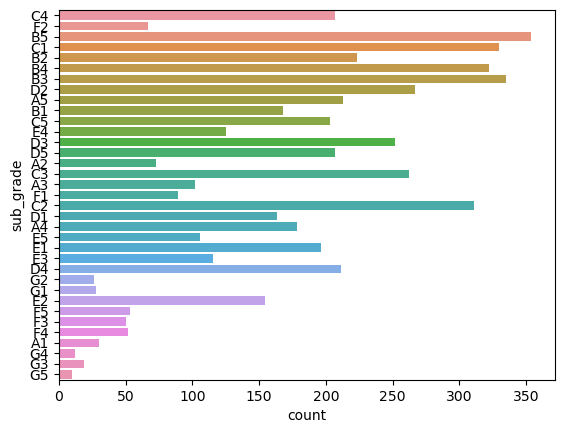

In [51]:
sns.countplot(y='sub_grade', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()

### Anaylysing employment length against charged off loans

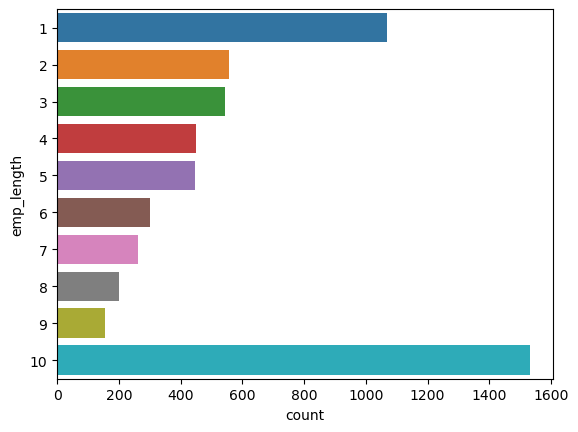

In [52]:
sns.countplot(y='emp_length', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()

### Anaylysing 'home_ownership' against charged off loans

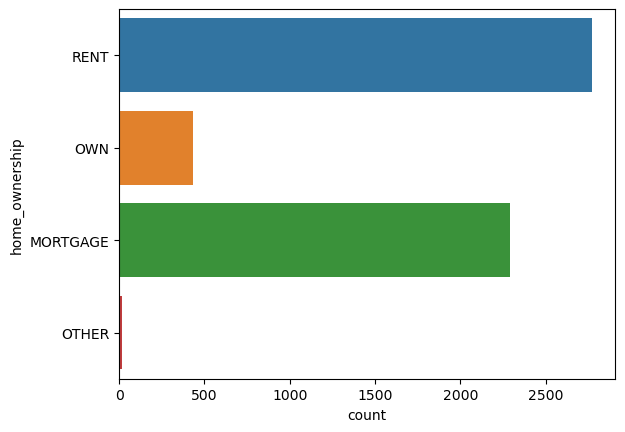

In [53]:
sns.countplot(y='home_ownership', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()

### Anaylysing 'annual_inc' against charged off loans by creating bins of annual income

In [54]:
loan_data['annual_inc'].describe()

count     38180.000000
mean      65889.084308
std       36388.027821
min        4000.000000
25%       40000.000000
50%       58000.000000
75%       81000.000000
max      260735.000000
Name: annual_inc, dtype: float64

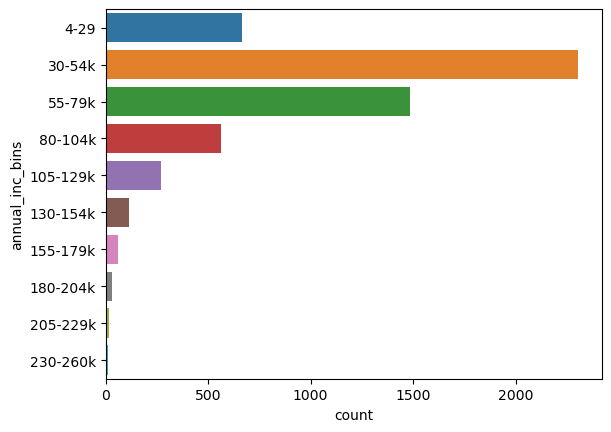

In [55]:
loan_data['annual_inc_bins'] = pd.cut(loan_data['annual_inc'], bins=10,precision =0,labels =['4-29','30-54k','55-79k','80-104k','105-129k','130-154k','155-179k','180-204k','205-229k','230-260k'])
sns.countplot(y='annual_inc_bins', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()

### Analysing 'Verification_status' against charged off status

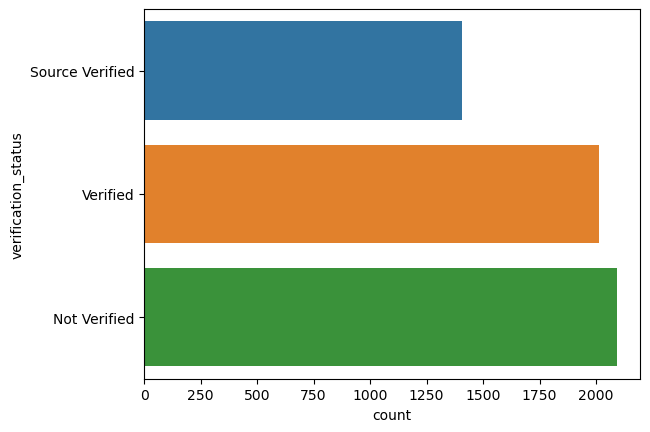

In [56]:
sns.countplot(y='verification_status', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()

### Analysing 'purpose' against charged off loans

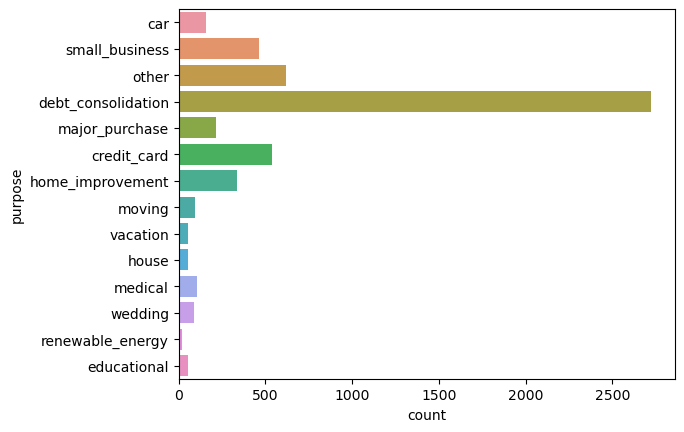

In [57]:
sns.countplot(y='purpose', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()

### Analysing 'dti' against charged off loans

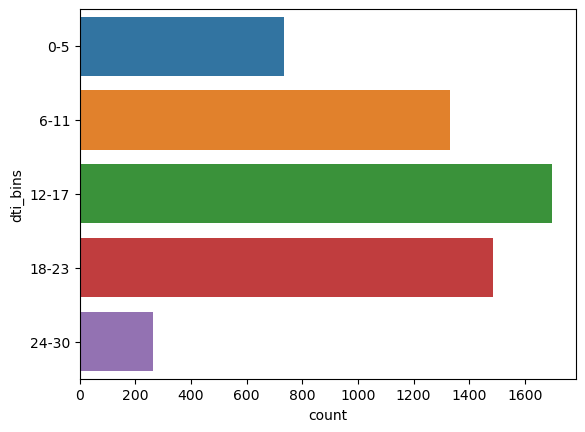

In [58]:
loan_data['dti_bins'] = pd.cut(loan_data['dti'], bins=5,precision =0,labels =['0-5','6-11','12-17','18-23','24-30'])
sns.countplot(y='dti_bins', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()

### Analysing 'delinq_2yrs', 'inq_last_6mths' and 'open_acc' against chanrged off loans

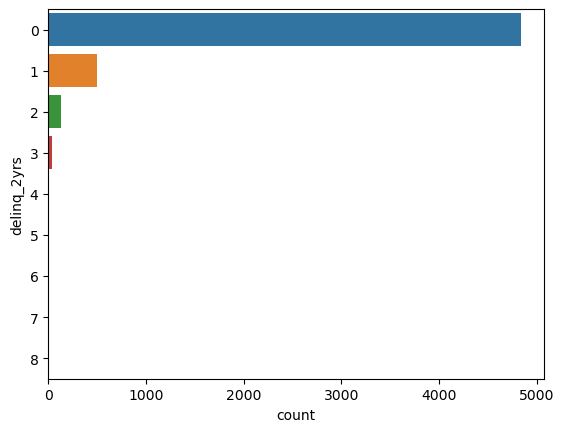

In [59]:
sns.countplot(y='delinq_2yrs', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()

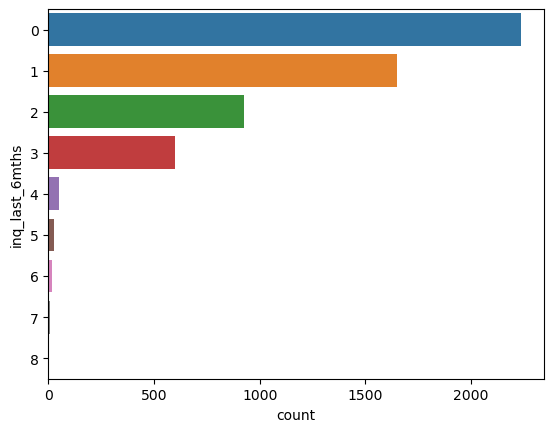

In [60]:
sns.countplot(y='inq_last_6mths', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()

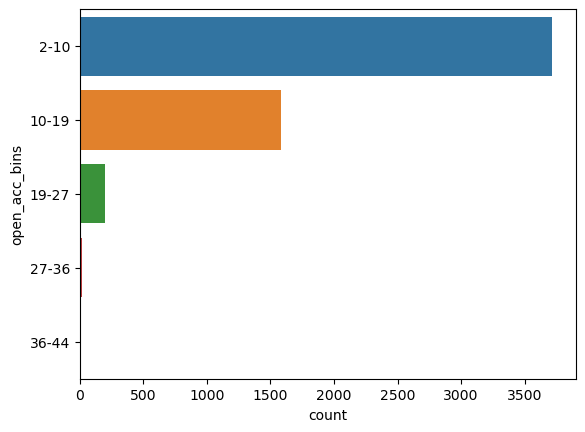

In [61]:
loan_data['open_acc_bins'] = pd.cut(loan_data['open_acc'],bins = 5,precision =0,labels=['2-10','10-19','19-27','27-36','36-44'])
sns.countplot(y='open_acc_bins', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()

### Analysing 'pub_rec' 'revol_bal', 'revol_util' against charged off loans

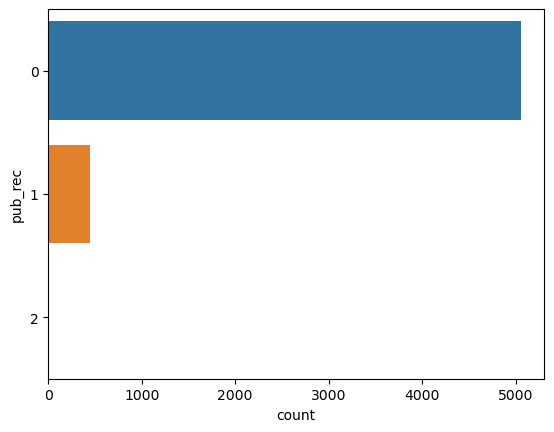

In [62]:
sns.countplot(y='pub_rec', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()

In [63]:
loan_data['revol_util'].describe()

count    38180.000000
mean        48.255605
std         28.321591
min          0.000000
25%         25.000000
50%         49.000000
75%         72.000000
max         99.000000
Name: revol_util, dtype: float64

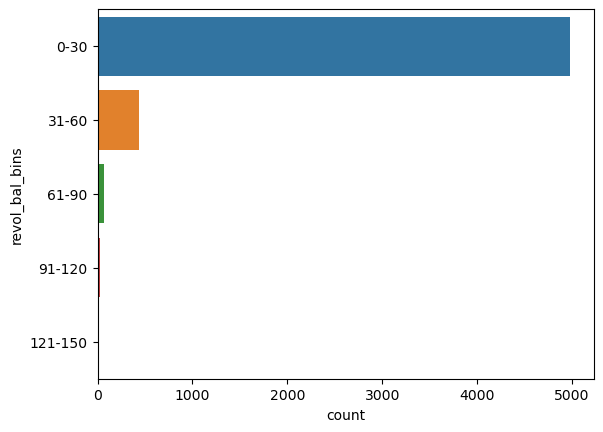

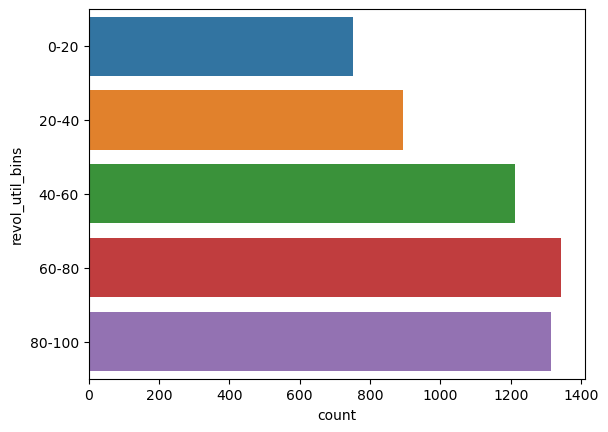

In [64]:
loan_data['revol_bal_bins'] = pd.cut(loan_data['revol_bal'], bins=5,labels=['0-30','31-60','61-90','91-120','121-150'])
sns.countplot(y='revol_bal_bins', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()
loan_data['revol_util_bins'] = pd.cut(loan_data['revol_util'], bins=5,precision =0,labels=['0-20','20-40','40-60','60-80','80-100'])
sns.countplot(y='revol_util_bins', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()

### Analysis 'total_acc', 'total_rec_prncp' and 'pub_rec_bankruptcies'

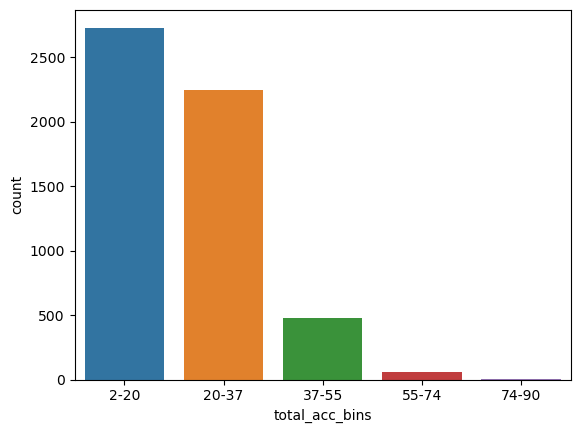

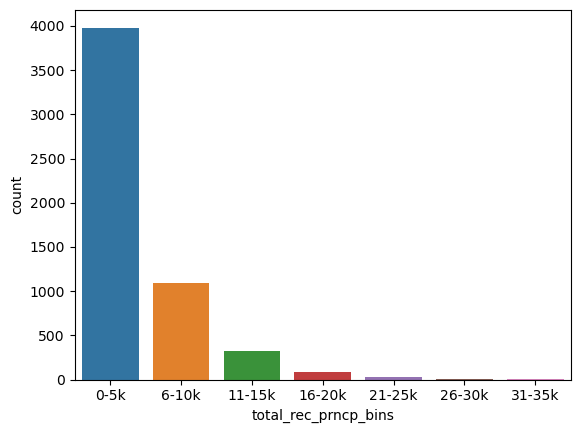

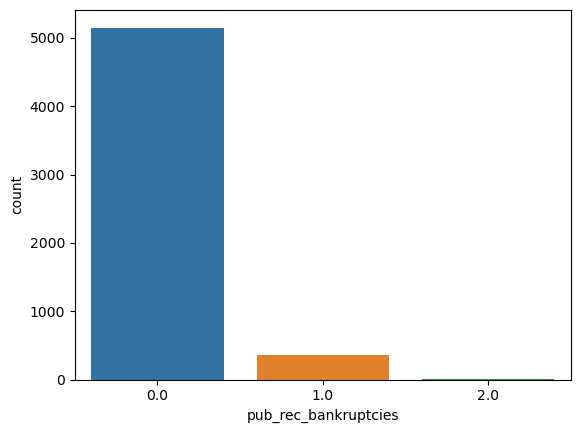

In [65]:
loan_data['total_acc_bins'] = pd.cut(loan_data['total_acc'], bins=5,precision =0,labels=['2-20','20-37','37-55','55-74','74-90'])
sns.countplot(x='total_acc_bins', data=loan_data[loan_data.loan_status == 'Charged Off'])
plt.show()
loan_data['total_rec_prncp_bins'] = pd.cut(loan_data['total_rec_prncp'], bins=7,precision =0,labels=['0-5k','6-10k','11-15k','16-20k','21-25k','26-30k','31-35k'])
sns.countplot(x='total_rec_prncp_bins', data=loan_data[loan_data.loan_status == 'Charged Off'])
plt.show()
sns.countplot(x='pub_rec_bankruptcies', data=loan_data[loan_data.loan_status == 'Charged Off'])
plt.show()


### Analysing by 'issue_d' and extracting month and year 

In [66]:
loan_data['issue_d'].value_counts()

Nov-11    2043
Dec-11    2029
Oct-11    1918
Sep-11    1888
Aug-11    1787
Jul-11    1726
Jun-11    1710
May-11    1594
Apr-11    1547
Mar-11    1426
Jan-11    1370
Feb-11    1290
Dec-10    1255
Nov-10    1115
Oct-10    1113
Jul-10    1112
Sep-10    1075
Aug-10    1069
Jun-10    1015
May-10     910
Apr-10     820
Mar-10     723
Feb-10     616
Dec-09     589
Nov-09     589
Jan-10     579
Oct-09     538
Sep-09     446
Aug-09     407
Jul-09     367
Jun-09     349
May-09     317
Apr-09     285
Mar-09     275
Feb-09     259
Jan-09     234
Mar-08     230
Dec-08     222
Nov-08     183
Feb-08     174
Jan-08     169
Apr-08     155
Oct-08      95
Dec-07      84
Jul-08      82
May-08      70
Aug-08      70
Jun-08      66
Oct-07      46
Nov-07      35
Aug-07      33
Sep-08      32
Jul-07      30
Sep-07      18
Jun-07       1
Name: issue_d, dtype: int64

In [67]:
## Extracting month and year
issue_d_month_year = loan_data['issue_d'].str.partition("-", True)     
loan_data['issue_month']=issue_d_month_year[0]                       
loan_data['issue_year']='20' + issue_d_month_year[2]

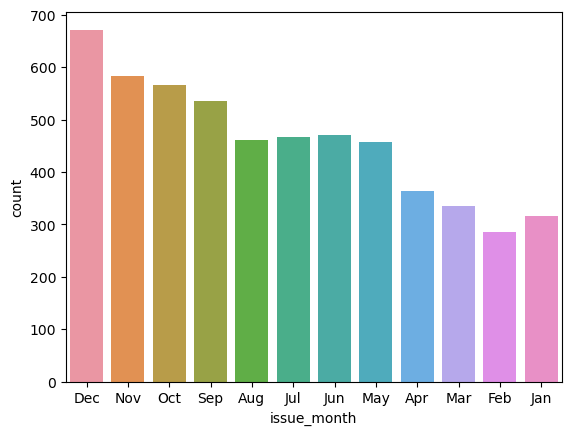

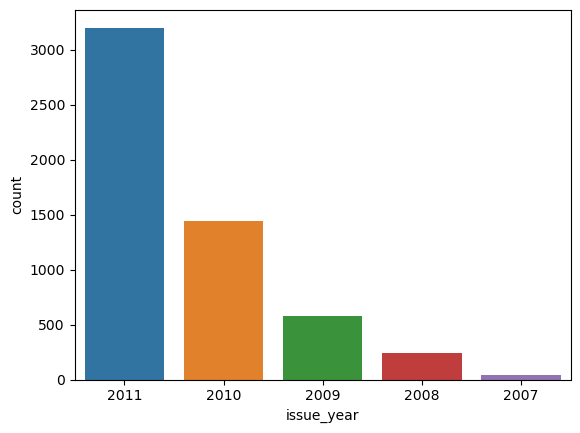

In [68]:
sns.countplot(x='issue_month', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()
sns.countplot(x='issue_year', data=loan_data[loan_data['loan_status']=='Charged Off'])
plt.show()

## Observations for the above Bivariate analysis 

## Multivariate analysis

<Figure size 1000x1000 with 0 Axes>

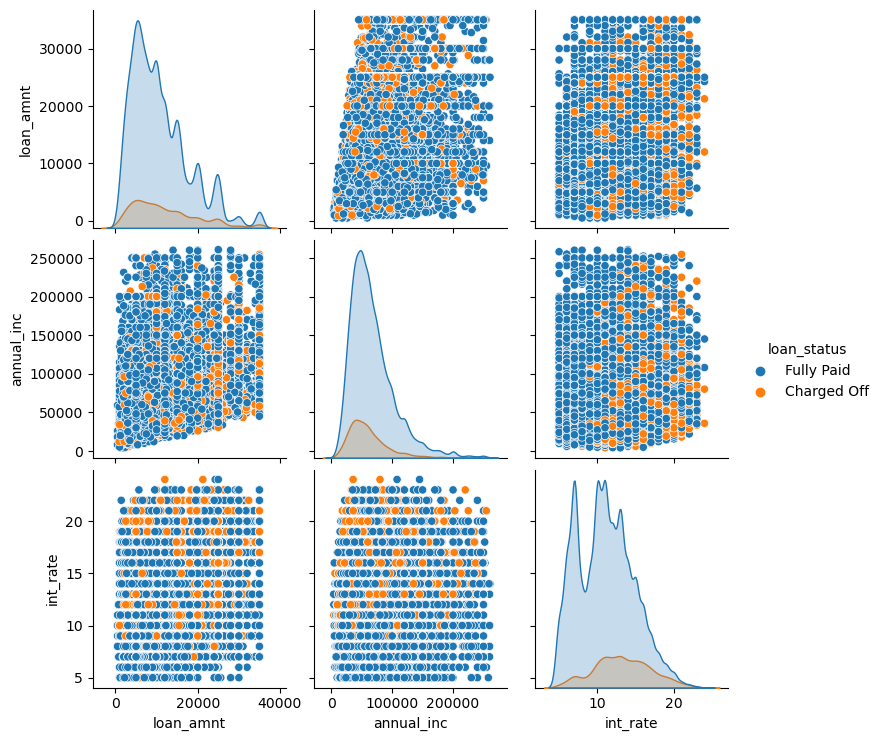

In [70]:
plt.figure(figsize=[10,10] )
sns.pairplot(loan_data[['loan_amnt', 'annual_inc','int_rate','loan_status']], 
             hue='loan_status')
plt.show()

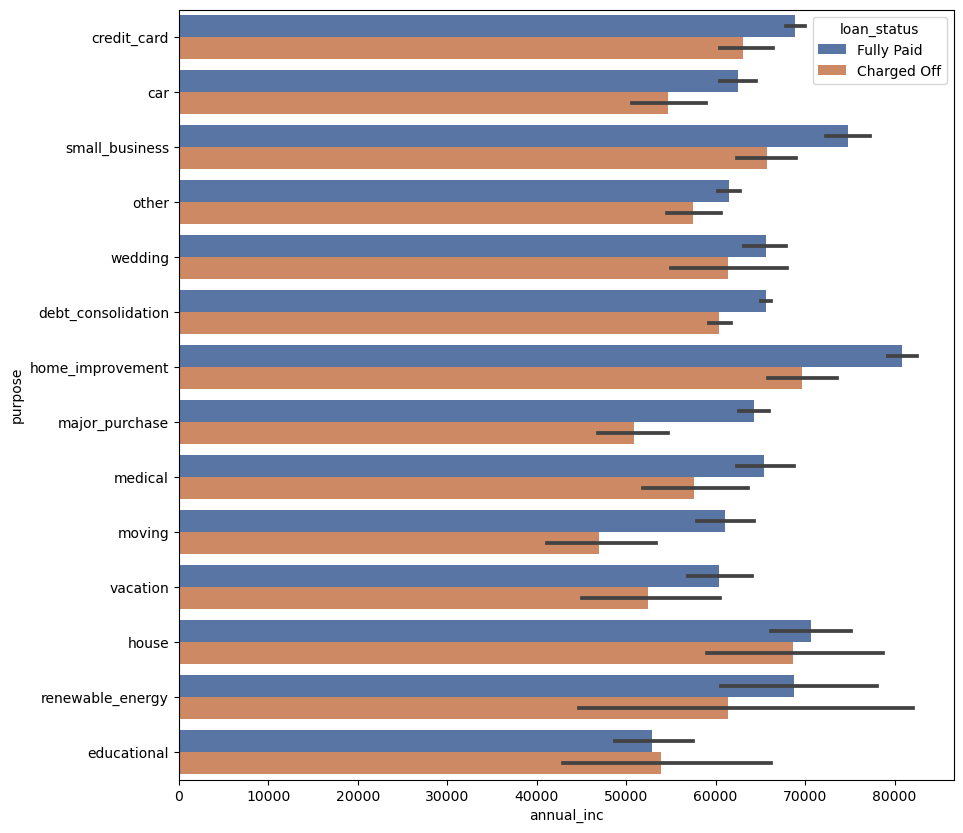

In [71]:
plt.figure(figsize=(10,10))
sns.barplot(data =loan_data,x='annual_inc', y='purpose', hue ='loan_status',palette="deep")
plt.show()

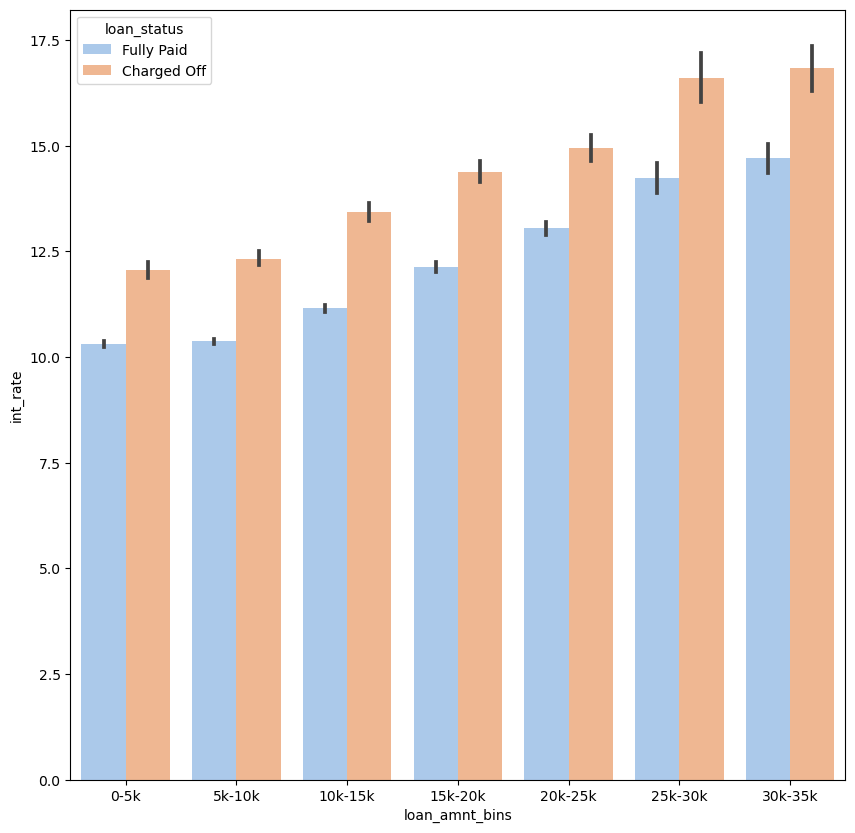

In [72]:
plt.figure(figsize=(10,10))
sns.barplot(data =loan_data,x='loan_amnt_bins', y='int_rate', hue ='loan_status',palette="pastel")
plt.show()

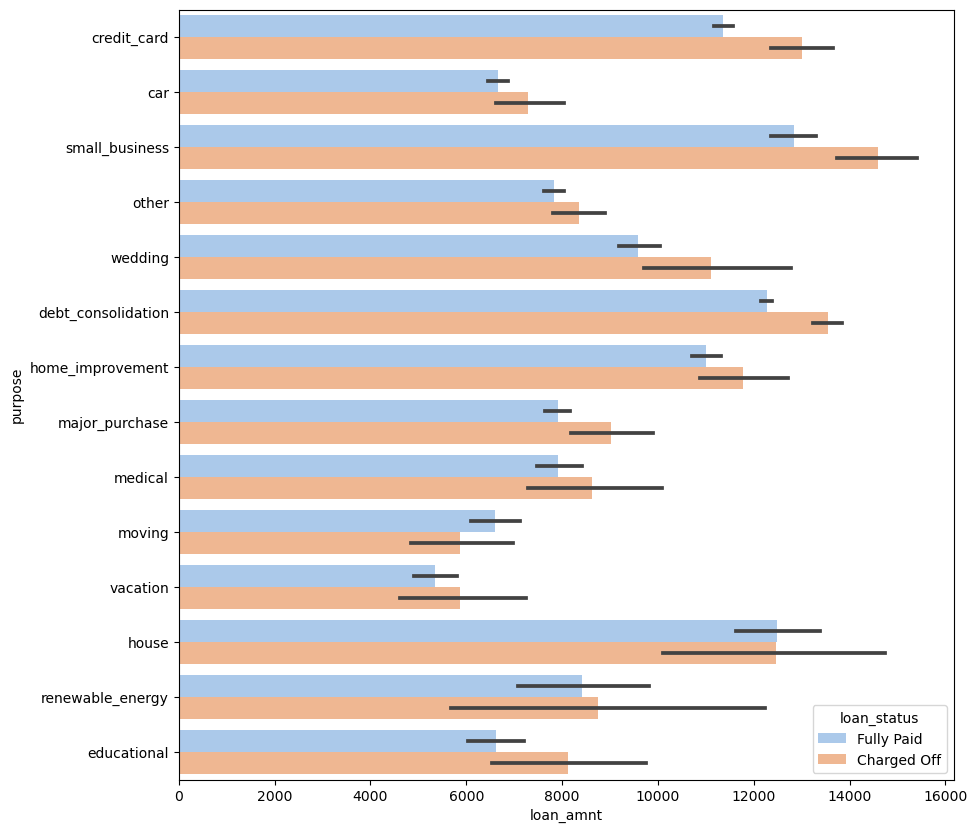

In [73]:
plt.figure(figsize=(10,10))
sns.barplot(data =loan_data,x='loan_amnt', y='purpose', hue ='loan_status',palette="pastel")
plt.show()

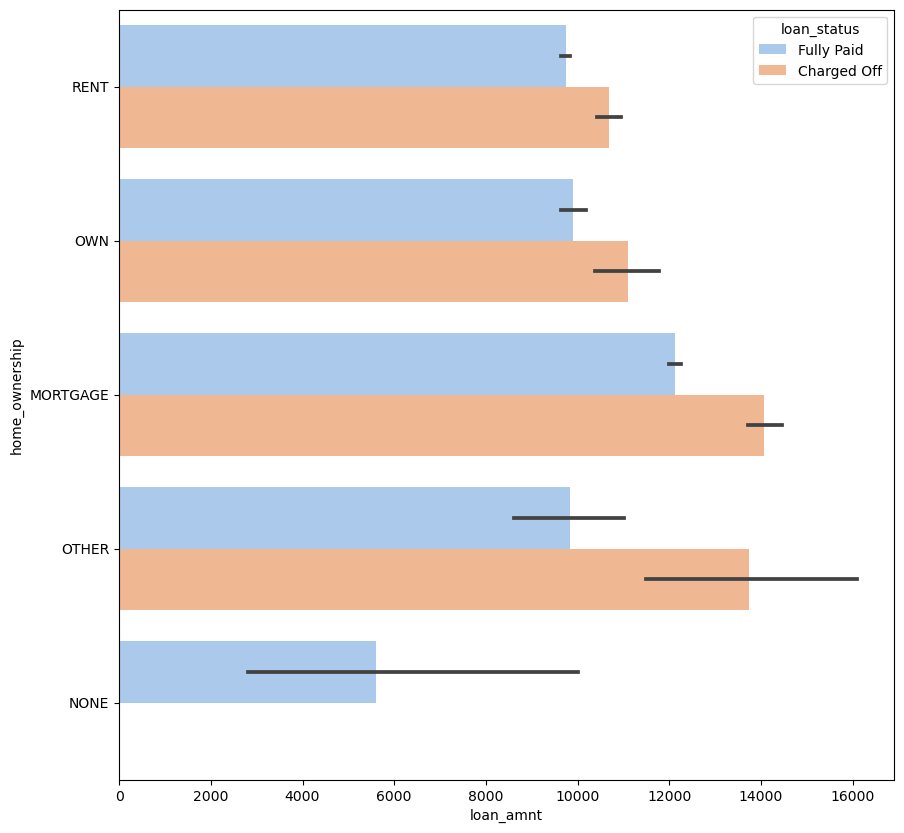

In [74]:
plt.figure(figsize=(10,10))
sns.barplot(data =loan_data,x='loan_amnt', y='home_ownership', hue ='loan_status',palette="pastel")
plt.show()

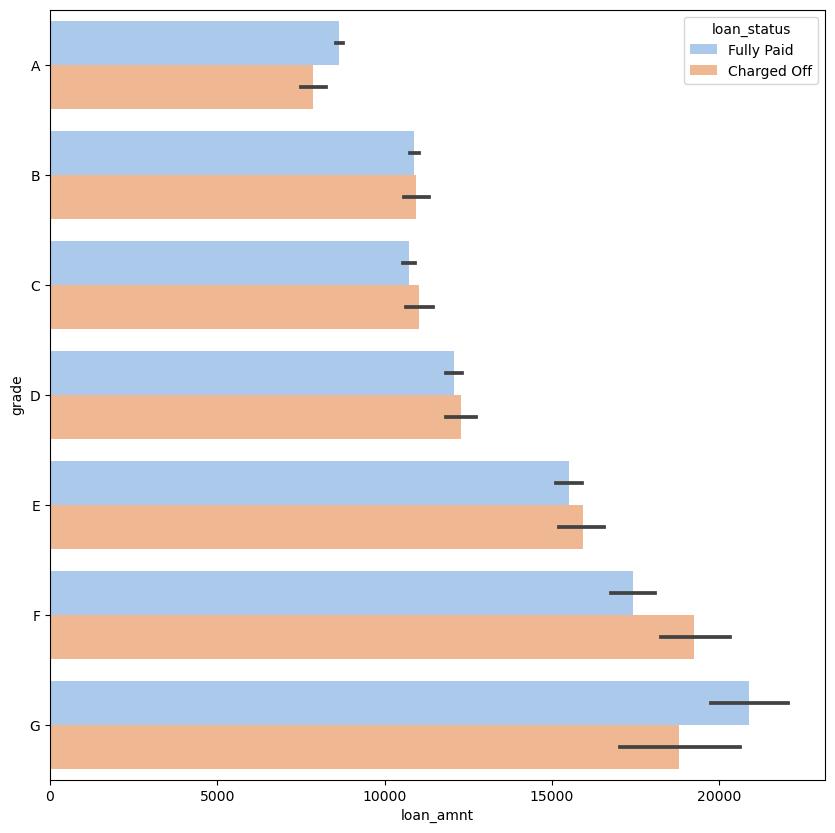

In [75]:
plt.figure(figsize=(10,10))
sns.barplot(data =loan_data,x='loan_amnt', y='grade', hue ='loan_status',palette="pastel", order=['A','B','C','D','E','F','G'])
plt.show()

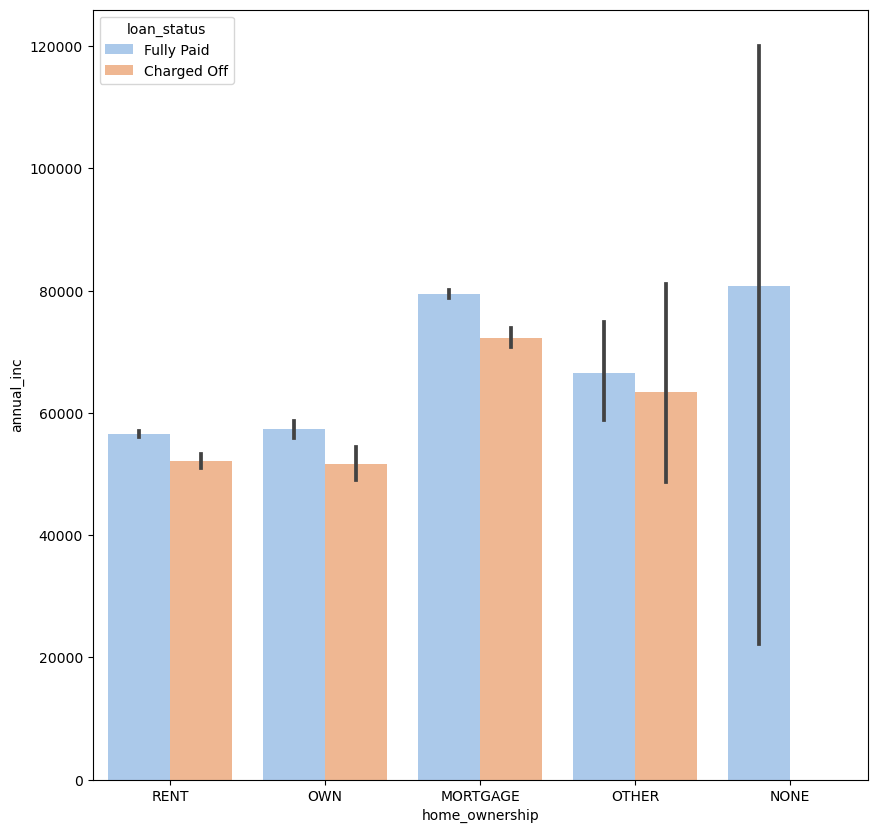

In [76]:
plt.figure(figsize=(10,10))
sns.barplot(data =loan_data,x='home_ownership', y='annual_inc', hue ='loan_status',palette="pastel")
plt.show()

## Obervations from Multivariate analysis above:

In [ ]:
- loan amount increases with the increase in annual_income
- interest rate increase with the increase in loan amount
- charged off loans are on the higher interest rates  or interest rates are high for changed off loans
- applicants taking loan for 'home' and 'home improvement' have annual income between 60-70k and have a higher probablity of defaulting
- applicants who have a MORTGAGE and an annual income of 60-70k are likely for default
- Grade F and applicants and loan amount between 15-20k
- application whose purpose is small business

## Correlation matrix

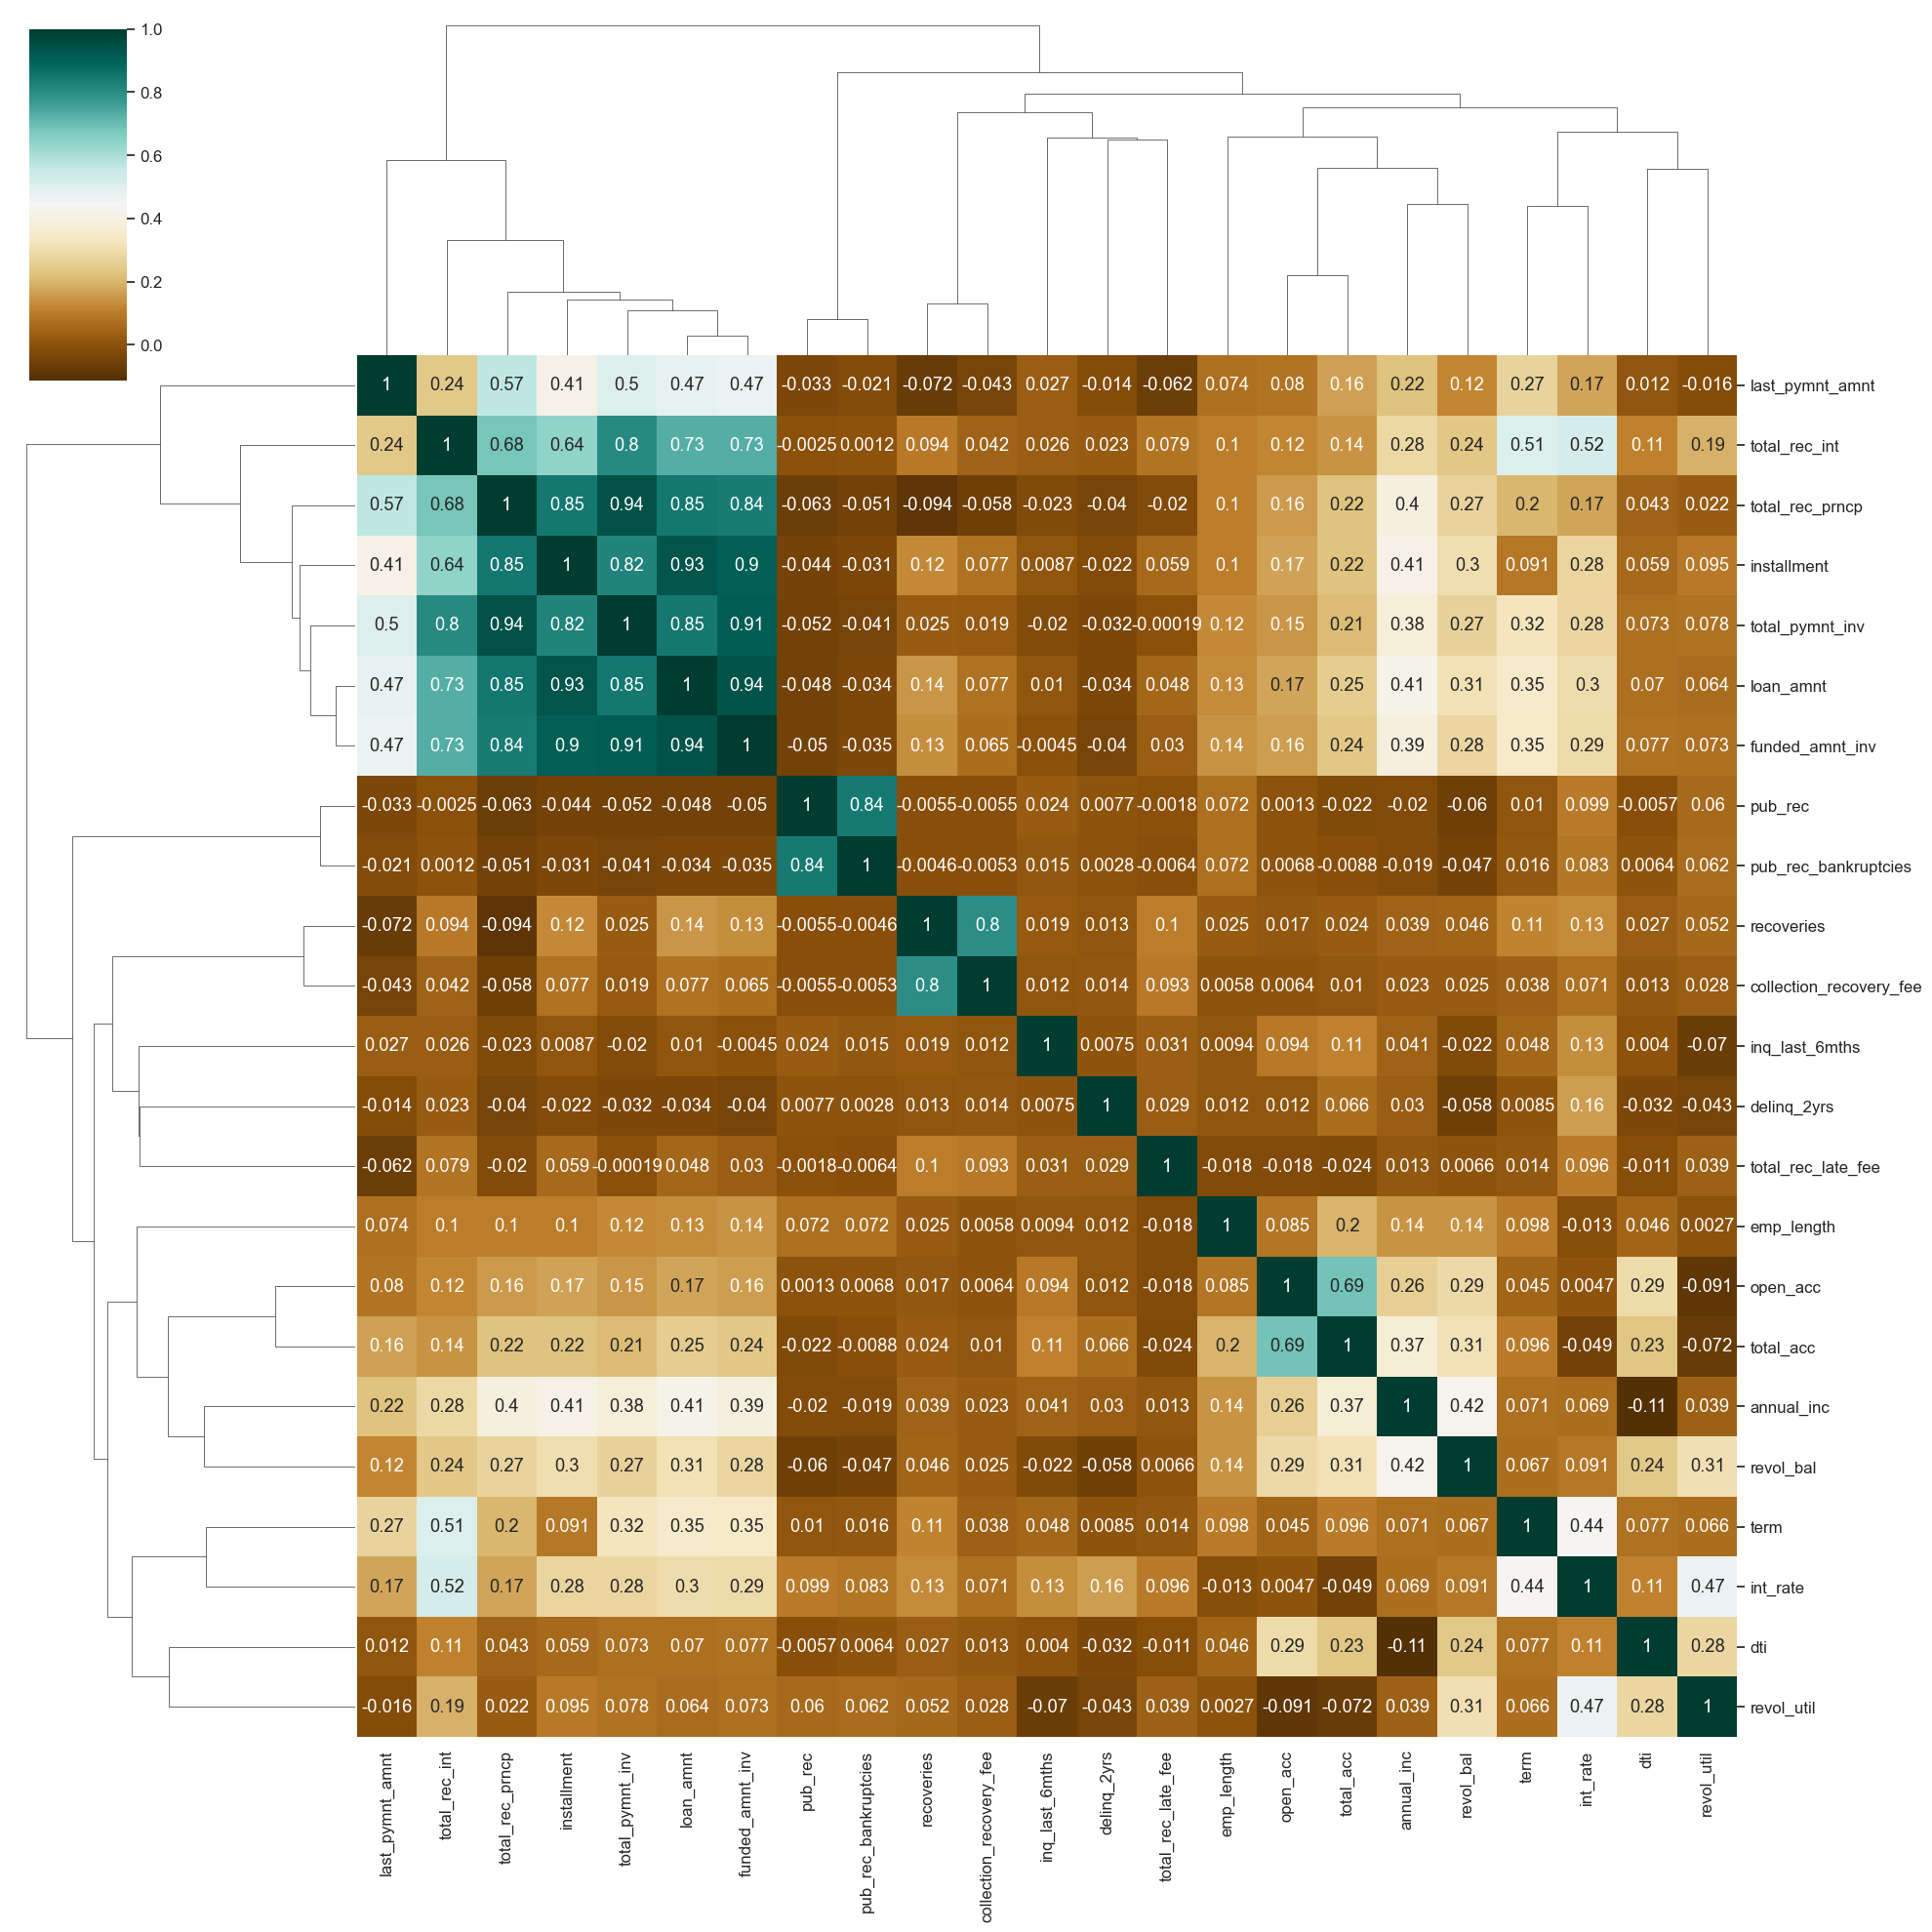

In [77]:
loan_data_correlation = loan_data.corr()
sns.set(font_scale=1.1)
sns.clustermap(loan_data_correlation,annot=True,figsize=(20, 20),cmap="BrBG")
plt.show()

## Observations from correlation matrix: